# Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import numpy as np
from gensim.models import LdaModel, CoherenceModel
import gensim.corpora as corpora
import itertools
from collections import Counter
import datetime
from gensim import models
#from gensim.models import Nmf
import numpy as np
import datetime
#import plotnine
import re
from itertools import combinations
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import bitermplus as btm

In [2]:
def join_comment_submission(ID):
    return comments_full[comments_full.post_id == ID].body.str.cat(sep = " ")

def get_lemma(word_tags):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma = []
    for element in word_tags:
        word = element[0][0]
        pos = element[0][1]
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                   "N": wordnet.NOUN,
                   "V": wordnet.VERB,
                   "R": wordnet.ADV}
        wordnet_pos = tag_dict.get(tag, wordnet.NOUN)
        lemma.append(wordnet_lemmatizer.lemmatize(word, wordnet_pos))
    return(lemma)

def lemmatize(tokens, allowed_postags=['NN', 'JJ', 'VBG', 'RB', 'JJR', 'JJS', 'RBR', 'RBS', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']):
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens_out = []
    for token in tokens:
        lemma = wordnet_lemmatizer.lemmatize(token)
        if nltk.pos_tag([lemma])[0][1] in allowed_postags:
            tokens_out.append(lemma)
    return tokens_out

def remove_stopwords(tokens):
    words = []
    for token in tokens:
        if len(token) > 1:
            if token not in stop_words_agg:
                words.append(token)
    return words

def jaccard_similarity(topic_1, topic_2):
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))           
    return float(len(intersection))/float(len(union))

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            #print(str(pair[0]) + " " + str(pair[1]))
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok.lower() in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok.lower() )
            yield tokens

# Preprocessing

In [3]:
stop = ["professor", "student", "college", "https", "com", "www", "amp", "reddit", "comment", "link", "don", "nan", "http"]
stop_words_agg = stopwords.words('english')+ stop

In [ ]:
pd.DataFrame(stop_words_agg).to_csv('stopwords.csv')

In [ ]:
submissions_full = pd.read_csv('submissions_full.csv', encoding = "UTF-8")
comments_full = pd.read_csv('comments_full.csv', encoding = "UTF-8")

In [ ]:
submissions_full.head(10)

Unnamed: 0                author  created_utc      id  num_comments  score  \
0           0       PradaPrincess91   1622519891  npl5ro            31      1   
1           1        PopCultureNerd   1622517103  npkd6c            47      1   
2           2              etoni888   1622508163  nphog5             8      1   
3           3  InvestigationTeamA34   1622507848  nphkua            53      1   
4           4  LowerAlternative7564   1622501952  npfoyv             4      1   
5           5   UnemployableVeggie1   1622496158  npdq5k             0      1   
6           6        PopCultureNerd   1622485579  np9x8h            39      2   
7           7      RIntegralDomainR   1622481820  np8jl2             0      2   
8           8       Dizzy_Comb_7486   1622476921  np6rfl            43      0   
9           9              xaanthar   1622471167  np4m3v            89      9   

                                            selftext  \
0                                                NaN   
1                                                NaN   
2  **Extension Request** \n\nI had an issue while...   
3                                                NaN   
4  The whiny ones who argue and act immature.  Ne...   
5                                          [removed]   
6  Hey all,\n\nPBS just published this piece abou...   
7                                                NaN   
8  I've given up on caring about my rmp profile e...   
9  I just graded an assignment.\n\nOn paper.\n\nW...   

                                               title  total_awards_received  \
0  I just created a new course! Now we are one of...                    0.0   
1  The Native Scholar Who Wasn’t - More than a de...                    0.0   
2                                  Accidental Poetry                    0.0   
3       What percent of students do you think cheat?                    0.0   
4  I’ve never seen the kinds of students you talk...                    0.0   
5  I would honestly rather get raped or beaten up...                    0.0   
6  "Older adults are heading to college in pursui...                    0.0   
7  This is something you've been missing from bei...                    0.0   
8  Is there any way to not have my ratemyprofesso...                    0.0   
9                   I just did a very strange thing.                    0.0   

        created  
0  1.622534e+09  
1  1.622532e+09  
2  1.622523e+09  
3  1.622522e+09  
4  1.622516e+09  
5  1.622511e+09  
6  1.622500e+09  
7  1.622496e+09  
8  1.622491e+09  
9  1.622486e+09

In [ ]:
comments_full.head(10)

Unnamed: 0                author  \
0           0             starfries   
1           1             starfries   
2           2          Ulrich_Plays   
3           3          Ulrich_Plays   
4           4             starfries   
5           5  InvestigationTeamA34   
6           6     sourdoughobsessed   
7           7            urnbabyurn   
8           8             Eigengrad   
9           9  InvestigationTeamA34   

                                                body  created_utc       id  \
0  Legend has it there once were students who eve...   1622519978  h05nu21   
1  I thought grading was always done in pen so st...   1622519861  h05nnj1   
2  You didn't, BUT you equated it to less than th...   1622519840  h05nmae   
3  It isn't one of constant crying for help with ...   1622519761  h05nhtv   
4  I'm so thankful the administration here agrees...   1622519654  h05nbro   
5                   You don't live a life on Reddit?   1622519593  h05n8c8   
6  You don’t focus on academics though. You focus...   1622519529  h05n4n6   
7  That’s lazy analysis. What about American cult...   1622519525  h05n4ff   
8  Lol, you called someone a liar upthread when y...   1622519504  h05n399   
9  The issue is if I start to try to socialize or...   1622519453  h05n09q   

     link_id  score       created  
0  t3_np4m3v      2  1.622534e+09  
1  t3_np4m3v      6  1.622534e+09  
2  t3_nphkua      2  1.622534e+09  
3  t3_nphkua      3  1.622534e+09  
4  t3_np4m3v      3  1.622534e+09  
5  t3_nphkua      0  1.622534e+09  
6  t3_nphkua      5  1.622534e+09  
7  t3_no6beu      1  1.622534e+09  
8  t3_nphkua      2  1.622534e+09  
9  t3_nphkua      1  1.622534e+09

## Connect post and comment data

In [ ]:
submissions_full['text'] = submissions_full.title.astype(str) + " " + submissions_full.selftext.astype(str)
submissions_full.head(10)

Unnamed: 0                author  created_utc      id  num_comments  score  \
0           0       PradaPrincess91   1622519891  npl5ro            31      1   
1           1        PopCultureNerd   1622517103  npkd6c            47      1   
2           2              etoni888   1622508163  nphog5             8      1   
3           3  InvestigationTeamA34   1622507848  nphkua            53      1   
4           4  LowerAlternative7564   1622501952  npfoyv             4      1   
5           5   UnemployableVeggie1   1622496158  npdq5k             0      1   
6           6        PopCultureNerd   1622485579  np9x8h            39      2   
7           7      RIntegralDomainR   1622481820  np8jl2             0      2   
8           8       Dizzy_Comb_7486   1622476921  np6rfl            43      0   
9           9              xaanthar   1622471167  np4m3v            89      9   

                                            selftext  \
0                                                NaN   
1                                                NaN   
2  **Extension Request** \n\nI had an issue while...   
3                                                NaN   
4  The whiny ones who argue and act immature.  Ne...   
5                                          [removed]   
6  Hey all,\n\nPBS just published this piece abou...   
7                                                NaN   
8  I've given up on caring about my rmp profile e...   
9  I just graded an assignment.\n\nOn paper.\n\nW...   

                                               title  total_awards_received  \
0  I just created a new course! Now we are one of...                    0.0   
1  The Native Scholar Who Wasn’t - More than a de...                    0.0   
2                                  Accidental Poetry                    0.0   
3       What percent of students do you think cheat?                    0.0   
4  I’ve never seen the kinds of students you talk...                    0.0   
5  I would honestly rather get raped or beaten up...                    0.0   
6  "Older adults are heading to college in pursui...                    0.0   
7  This is something you've been missing from bei...                    0.0   
8  Is there any way to not have my ratemyprofesso...                    0.0   
9                   I just did a very strange thing.                    0.0   

        created                                               text  
0  1.622534e+09  I just created a new course! Now we are one of...  
1  1.622532e+09  The Native Scholar Who Wasn’t - More than a de...  
2  1.622523e+09  Accidental Poetry **Extension Request** \n\nI ...  
3  1.622522e+09   What percent of students do you think cheat? nan  
4  1.622516e+09  I’ve never seen the kinds of students you talk...  
5  1.622511e+09  I would honestly rather get raped or beaten up...  
6  1.622500e+09  "Older adults are heading to college in pursui...  
7  1.622496e+09  This is something you've been missing from bei...  
8  1.622491e+09  Is there any way to not have my ratemyprofesso...  
9  1.622486e+09  I just did a very strange thing. I just graded...

In [ ]:
submissions_full = submissions_full.drop(['Unnamed: 0', 'author', 'created_utc', 'num_comments', 'score', \
                                          'selftext', 'title', 'total_awards_received'], axis = 1)
submissions_full.head(10)

id       created                                               text
0  npl5ro  1.622534e+09  I just created a new course! Now we are one of...
1  npkd6c  1.622532e+09  The Native Scholar Who Wasn’t - More than a de...
2  nphog5  1.622523e+09  Accidental Poetry **Extension Request** \n\nI ...
3  nphkua  1.622522e+09   What percent of students do you think cheat? nan
4  npfoyv  1.622516e+09  I’ve never seen the kinds of students you talk...
5  npdq5k  1.622511e+09  I would honestly rather get raped or beaten up...
6  np9x8h  1.622500e+09  "Older adults are heading to college in pursui...
7  np8jl2  1.622496e+09  This is something you've been missing from bei...
8  np6rfl  1.622491e+09  Is there any way to not have my ratemyprofesso...
9  np4m3v  1.622486e+09  I just did a very strange thing. I just graded...

In [ ]:
comments_full['post_id'] = comments_full.link_id.str.slice(3, )
comments_full.head(10)

Unnamed: 0                author  \
0           0             starfries   
1           1             starfries   
2           2          Ulrich_Plays   
3           3          Ulrich_Plays   
4           4             starfries   
5           5  InvestigationTeamA34   
6           6     sourdoughobsessed   
7           7            urnbabyurn   
8           8             Eigengrad   
9           9  InvestigationTeamA34   

                                                body  created_utc       id  \
0  Legend has it there once were students who eve...   1622519978  h05nu21   
1  I thought grading was always done in pen so st...   1622519861  h05nnj1   
2  You didn't, BUT you equated it to less than th...   1622519840  h05nmae   
3  It isn't one of constant crying for help with ...   1622519761  h05nhtv   
4  I'm so thankful the administration here agrees...   1622519654  h05nbro   
5                   You don't live a life on Reddit?   1622519593  h05n8c8   
6  You don’t focus on academics though. You focus...   1622519529  h05n4n6   
7  That’s lazy analysis. What about American cult...   1622519525  h05n4ff   
8  Lol, you called someone a liar upthread when y...   1622519504  h05n399   
9  The issue is if I start to try to socialize or...   1622519453  h05n09q   

     link_id  score       created post_id  
0  t3_np4m3v      2  1.622534e+09  np4m3v  
1  t3_np4m3v      6  1.622534e+09  np4m3v  
2  t3_nphkua      2  1.622534e+09  nphkua  
3  t3_nphkua      3  1.622534e+09  nphkua  
4  t3_np4m3v      3  1.622534e+09  np4m3v  
5  t3_nphkua      0  1.622534e+09  nphkua  
6  t3_nphkua      5  1.622534e+09  nphkua  
7  t3_no6beu      1  1.622534e+09  no6beu  
8  t3_nphkua      2  1.622534e+09  nphkua  
9  t3_nphkua      1  1.622534e+09  nphkua

In [ ]:
comments_full = comments_full.drop(['Unnamed: 0', 'author', 'created_utc', 'id', \
                                    'link_id', 'score'], axis = 1)
comments_full.head(10)

body       created post_id
0  Legend has it there once were students who eve...  1.622534e+09  np4m3v
1  I thought grading was always done in pen so st...  1.622534e+09  np4m3v
2  You didn't, BUT you equated it to less than th...  1.622534e+09  nphkua
3  It isn't one of constant crying for help with ...  1.622534e+09  nphkua
4  I'm so thankful the administration here agrees...  1.622534e+09  np4m3v
5                   You don't live a life on Reddit?  1.622534e+09  nphkua
6  You don’t focus on academics though. You focus...  1.622534e+09  nphkua
7  That’s lazy analysis. What about American cult...  1.622534e+09  no6beu
8  Lol, you called someone a liar upthread when y...  1.622534e+09  nphkua
9  The issue is if I start to try to socialize or...  1.622534e+09  nphkua

## Link submissions and comment data

In [ ]:
posts_full = submissions_full
posts_full['comments'] = posts_full.id.apply(join_comment_submission)
posts_full.head(10)

id       created                                               text  \
0  npl5ro  1.622534e+09  I just created a new course! Now we are one of...   
1  npkd6c  1.622532e+09  The Native Scholar Who Wasn’t - More than a de...   
2  nphog5  1.622523e+09  Accidental Poetry **Extension Request** \n\nI ...   
3  nphkua  1.622522e+09   What percent of students do you think cheat? nan   
4  npfoyv  1.622516e+09  I’ve never seen the kinds of students you talk...   
5  npdq5k  1.622511e+09  I would honestly rather get raped or beaten up...   
6  np9x8h  1.622500e+09  "Older adults are heading to college in pursui...   
7  np8jl2  1.622496e+09  This is something you've been missing from bei...   
8  np6rfl  1.622491e+09  Is there any way to not have my ratemyprofesso...   
9  np4m3v  1.622486e+09  I just did a very strange thing. I just graded...   

                                            comments  
0                                                     
1  I thought the article was referring to Elizabe...  
2  Both are direct pastes from student emails. Th...  
3  You didn't, BUT you equated it to less than th...  
4  [removed] Why do I suspect that this isn't in ...  
5                                                     
6  Why are you so cruel? The world needs baristas...  
7                                                     
8  You are giving RMP too much weight.  Just igno...  
9  Legend has it there once were students who eve...

In [ ]:
posts_full['full_text'] = posts_full.text.str.cat(posts_full.comments, sep = " ", na_rep = '')
posts_full.head(10)

id       created                                               text  \
0  npl5ro  1.622534e+09  I just created a new course! Now we are one of...   
1  npkd6c  1.622532e+09  The Native Scholar Who Wasn’t - More than a de...   
2  nphog5  1.622523e+09  Accidental Poetry **Extension Request** \n\nI ...   
3  nphkua  1.622522e+09   What percent of students do you think cheat? nan   
4  npfoyv  1.622516e+09  I’ve never seen the kinds of students you talk...   
5  npdq5k  1.622511e+09  I would honestly rather get raped or beaten up...   
6  np9x8h  1.622500e+09  "Older adults are heading to college in pursui...   
7  np8jl2  1.622496e+09  This is something you've been missing from bei...   
8  np6rfl  1.622491e+09  Is there any way to not have my ratemyprofesso...   
9  np4m3v  1.622486e+09  I just did a very strange thing. I just graded...   

                                            comments  \
0                                                      
1  I thought the article was referring to Elizabe...   
2  Both are direct pastes from student emails. Th...   
3  You didn't, BUT you equated it to less than th...   
4  [removed] Why do I suspect that this isn't in ...   
5                                                      
6  Why are you so cruel? The world needs baristas...   
7                                                      
8  You are giving RMP too much weight.  Just igno...   
9  Legend has it there once were students who eve...   

                                           full_text  
0  I just created a new course! Now we are one of...  
1  The Native Scholar Who Wasn’t - More than a de...  
2  Accidental Poetry **Extension Request** \n\nI ...  
3  What percent of students do you think cheat? n...  
4  I’ve never seen the kinds of students you talk...  
5  I would honestly rather get raped or beaten up...  
6  "Older adults are heading to college in pursui...  
7  This is something you've been missing from bei...  
8  Is there any way to not have my ratemyprofesso...  
9  I just did a very strange thing. I just graded...

In [ ]:
posts_full = posts_full.drop(['id', 'text', 'comments'], axis = 1)
posts_full.head(10)

created                                          full_text
0  1.622534e+09  I just created a new course! Now we are one of...
1  1.622532e+09  The Native Scholar Who Wasn’t - More than a de...
2  1.622523e+09  Accidental Poetry **Extension Request** \n\nI ...
3  1.622522e+09  What percent of students do you think cheat? n...
4  1.622516e+09  I’ve never seen the kinds of students you talk...
5  1.622511e+09  I would honestly rather get raped or beaten up...
6  1.622500e+09  "Older adults are heading to college in pursui...
7  1.622496e+09  This is something you've been missing from bei...
8  1.622491e+09  Is there any way to not have my ratemyprofesso...
9  1.622486e+09  I just did a very strange thing. I just graded...

In [ ]:
posts_full.head(50)

created                                          full_text
0   1.622534e+09  i just created a new course now we are one of ...
1   1.622532e+09  the native scholar who wasn t more than a deca...
2   1.622523e+09  accidental poetry extension request i had an i...
3   1.622522e+09  what percent of students do you think cheat na...
4   1.622516e+09  i ve never seen the kinds of students you talk...
5   1.622511e+09  i would honestly rather get raped or beaten up...
6   1.622500e+09   older adults are heading to college in pursui...
7   1.622496e+09  this is something you ve been missing from bei...
8   1.622491e+09  is there any way to not have my ratemyprofesso...
9   1.622486e+09  i just did a very strange thing i just graded ...
10  1.622477e+09  what are some game changing items that you hav...
11  1.622454e+09                             academic aita deleted 
12  1.622450e+09  students completing assignments on their phone...
13  1.622445e+09  vent time i get it you resent that you have to...
14  1.622439e+09  syllabus with no letter grade assignment is c ...
15  1.622438e+09  will a low student to faculty ratio lt provide...
16  1.622438e+09  when making a decision about where to attend u...
17  1.622437e+09  how is a c my kid just finished his third seme...
18  1.622435e+09   small success sunday weekly thread welcome to...
19  1.622427e+09  united states adjuncts or lecturers that have ...
20  1.622424e+09  whatsapp and discord illegal group collaborati...
21  1.622423e+09  whatsapp and discord cheating to start i am a ...
22  1.622422e+09  providing solutions for the exams i sent a stu...
23  1.622421e+09               for those who could use a laugh nan 
24  1.622421e+09          the types of reviewers you will meet nan 
25  1.622421e+09  missing the first few classes don t we all lov...
26  1.622413e+09  expectations vs reality about problem solving ...
27  1.622400e+09                  slow internet connection removed 
28  1.622393e+09  so military secrets are showing up on chegg an...
29  1.622376e+09  advice for responding to poor student eval sta...
30  1.622368e+09  i am a former student wanting to ask my profes...
31  1.622364e+09  just venting about trivial things i am just co...
32  1.622363e+09         transfer being poached by phd program nan 
33  1.622355e+09  in an unprecedented move astronomer geoff marc...
34  1.622353e+09  plagiarism chegg hello i d like to ask a quest...
35  1.622351e+09  ok i found this pretty funny as someone who do...
36  1.622349e+09  student obsessed with grades ranking i feel li...
37  1.622346e+09  how do you stop getting the urge to look onlin...
38  1.622345e+09  how do you stop getting the urge to look onlin...
39  1.622342e+09  got this tattoo that i feel captures how i oft...
40  1.622335e+09  creating tournament brackets for courses like ...
41  1.622331e+09  re end of semester grading strategy nan well t...
42  1.622328e+09  end of semester thelma and louise style well i...
43  1.622325e+09  taxonomy question easy one here perhaps can a ...
44  1.622323e+09  do you allow students to text you i have some ...
45  1.622318e+09  discussion on blog post i want to quit my job ...
46  1.622307e+09  pedagogy resources i have very few responsibil...
47  1.622304e+09  end of the semester grading strategy nan the a...
48  1.622304e+09  open book note testing is this becoming more c...
49  1.622300e+09  college professors of reddit do you ever read ...

In [ ]:
posts_full.to_csv('posts_full.csv')

## Clean text

In [ ]:
posts_clean = posts_full
posts_clean.full_text = posts_clean.full_text.replace('[removed]', " ")
posts_clean.full_text = posts_clean.full_text.replace('[deleted]', " ")
posts_clean.full_text = posts_clean.full_text.replace('\n', " ")
posts_clean.full_text = posts_clean.full_text.replace("[^a-zA-Z]+", " ", regex = True)
posts_clean.full_text = posts_clean.full_text.str.lower()
posts_clean.head(10)

created                                          full_text
0  1.622534e+09  i just created a new course now we are one of ...
1  1.622532e+09  the native scholar who wasn t more than a deca...
2  1.622523e+09  accidental poetry extension request i had an i...
3  1.622522e+09  what percent of students do you think cheat na...
4  1.622516e+09  i ve never seen the kinds of students you talk...
5  1.622511e+09  i would honestly rather get raped or beaten up...
6  1.622500e+09   older adults are heading to college in pursui...
7  1.622496e+09  this is something you ve been missing from bei...
8  1.622491e+09  is there any way to not have my ratemyprofesso...
9  1.622486e+09  i just did a very strange thing i just graded ...

In [ ]:
posts_clean.to_csv('posts_clean.csv')

## Lemmatization and stopword removal

In [ ]:
stop_words_agg

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
posts_clean["tokens"] = posts_clean.full_text.apply(word_tokenize)
posts_clean.head(10)

created                                          full_text  \
0  1.622534e+09  i just created a new course now we are one of ...   
1  1.622532e+09  the native scholar who wasn t more than a deca...   
2  1.622523e+09  accidental poetry extension request i had an i...   
3  1.622522e+09  what percent of students do you think cheat na...   
4  1.622516e+09  i ve never seen the kinds of students you talk...   
5  1.622511e+09  i would honestly rather get raped or beaten up...   
6  1.622500e+09   older adults are heading to college in pursui...   
7  1.622496e+09  this is something you ve been missing from bei...   
8  1.622491e+09  is there any way to not have my ratemyprofesso...   
9  1.622486e+09  i just did a very strange thing i just graded ...   

                                              tokens  \
0  [i, just, created, a, new, course, now, we, ar...   
1  [the, native, scholar, who, wasn, t, more, tha...   
2  [accidental, poetry, extension, request, i, ha...   
3  [what, percent, of, students, do, you, think, ...   
4  [i, ve, never, seen, the, kinds, of, students,...   
5  [i, would, honestly, rather, get, raped, or, b...   
6  [older, adults, are, heading, to, college, in,...   
7  [this, is, something, you, ve, been, missing, ...   
8  [is, there, any, way, to, not, have, my, ratem...   
9  [i, just, did, a, very, strange, thing, i, jus...   

                                       tokens_nostop  
0  [created, new, course, one, social, work, prog...  
1  [native, scholar, decade, ago, prominent, acad...  
2  [accidental, poetry, extension, request, issue...  
3  [percent, students, think, cheat, nan, equated...  
4  [never, seen, kinds, students, talk, whiny, on...  
5  [would, honestly, rather, get, raped, beaten, ...  
6  [older, adults, heading, pursuit, new, opportu...  
7  [something, missing, f, f, come, know, missed,...  
8  [way, ratemyprofessors, profile, show, google,...  
9  [strange, thing, graded, assignment, paper, pe...

In [ ]:
posts_clean["tokens_nostop"] = posts_clean.tokens.apply(remove_stopwords)
posts_clean.head(10)

created                                          full_text  \
0  1.622534e+09  i just created a new course now we are one of ...   
1  1.622532e+09  the native scholar who wasn t more than a deca...   
2  1.622523e+09  accidental poetry extension request i had an i...   
3  1.622522e+09  what percent of students do you think cheat na...   
4  1.622516e+09  i ve never seen the kinds of students you talk...   
5  1.622511e+09  i would honestly rather get raped or beaten up...   
6  1.622500e+09   older adults are heading to college in pursui...   
7  1.622496e+09  this is something you ve been missing from bei...   
8  1.622491e+09  is there any way to not have my ratemyprofesso...   
9  1.622486e+09  i just did a very strange thing i just graded ...   

                                              tokens  \
0  [i, just, created, a, new, course, now, we, ar...   
1  [the, native, scholar, who, wasn, t, more, tha...   
2  [accidental, poetry, extension, request, i, ha...   
3  [what, percent, of, students, do, you, think, ...   
4  [i, ve, never, seen, the, kinds, of, students,...   
5  [i, would, honestly, rather, get, raped, or, b...   
6  [older, adults, are, heading, to, college, in,...   
7  [this, is, something, you, ve, been, missing, ...   
8  [is, there, any, way, to, not, have, my, ratem...   
9  [i, just, did, a, very, strange, thing, i, jus...   

                                       tokens_nostop  
0  [created, new, course, one, social, work, prog...  
1  [native, scholar, decade, ago, prominent, acad...  
2  [accidental, poetry, extension, request, issue...  
3  [percent, students, think, cheat, equated, les...  
4  [never, seen, kinds, students, talk, whiny, on...  
5  [would, honestly, rather, get, raped, beaten, ...  
6  [older, adults, heading, pursuit, new, opportu...  
7           [something, missing, come, know, missed]  
8  [way, ratemyprofessors, profile, show, google,...  
9  [strange, thing, graded, assignment, paper, pe...

In [ ]:
posts_clean["lemmatized"] = posts_clean.tokens_nostop.apply(lemmatize)

In [ ]:
posts_clean.head(10)

created                                          full_text  \
0  1.622534e+09  i just created a new course now we are one of ...   
1  1.622532e+09  the native scholar who wasn t more than a deca...   
2  1.622523e+09  accidental poetry extension request i had an i...   
3  1.622522e+09  what percent of students do you think cheat na...   
4  1.622516e+09  i ve never seen the kinds of students you talk...   
5  1.622511e+09  i would honestly rather get raped or beaten up...   
6  1.622500e+09   older adults are heading to college in pursui...   
7  1.622496e+09  this is something you ve been missing from bei...   
8  1.622491e+09  is there any way to not have my ratemyprofesso...   
9  1.622486e+09  i just did a very strange thing i just graded ...   

                                              tokens  \
0  [i, just, created, a, new, course, now, we, ar...   
1  [the, native, scholar, who, wasn, t, more, tha...   
2  [accidental, poetry, extension, request, i, ha...   
3  [what, percent, of, students, do, you, think, ...   
4  [i, ve, never, seen, the, kinds, of, students,...   
5  [i, would, honestly, rather, get, raped, or, b...   
6  [older, adults, are, heading, to, college, in,...   
7  [this, is, something, you, ve, been, missing, ...   
8  [is, there, any, way, to, not, have, my, ratem...   
9  [i, just, did, a, very, strange, thing, i, jus...   

                                       tokens_nostop  \
0  [created, new, course, one, social, work, prog...   
1  [native, scholar, decade, ago, prominent, acad...   
2  [accidental, poetry, extension, request, issue...   
3  [percent, students, think, cheat, equated, les...   
4  [never, seen, kinds, students, talk, whiny, on...   
5  [would, honestly, rather, get, raped, beaten, ...   
6  [older, adults, heading, pursuit, new, opportu...   
7           [something, missing, come, know, missed]   
8  [way, ratemyprofessors, profile, show, google,...   
9  [strange, thing, graded, assignment, paper, pe...   

                                          lemmatized  
0  [created, new, course, social, work, program, ...  
1  [native, scholar, decade, ago, prominent, acad...  
2  [accidental, poetry, extension, request, issue...  
3  [percent, student, think, cheat, equated, le, ...  
4  [never, seen, kind, student, talk, whiny, argu...  
5  [honestly, rather, raped, beaten, rather, suff...  
6  [older, adult, heading, pursuit, new, opportun...  
7                       [something, missing, missed]  
8  [way, profile, show, google, search, name, giv...  
9  [strange, thing, graded, assignment, paper, ru...

In [ ]:
posts_clean["lemmatized_text"] = posts_clean.lemmatized.apply(' '.join)
posts_clean.head(10)

created                                          full_text  \
0  1.622534e+09  i just created a new course now we are one of ...   
1  1.622532e+09  the native scholar who wasn t more than a deca...   
2  1.622523e+09  accidental poetry extension request i had an i...   
3  1.622522e+09  what percent of students do you think cheat na...   
4  1.622516e+09  i ve never seen the kinds of students you talk...   
5  1.622511e+09  i would honestly rather get raped or beaten up...   
6  1.622500e+09   older adults are heading to college in pursui...   
7  1.622496e+09  this is something you ve been missing from bei...   
8  1.622491e+09  is there any way to not have my ratemyprofesso...   
9  1.622486e+09  i just did a very strange thing i just graded ...   

                                              tokens  \
0  [i, just, created, a, new, course, now, we, ar...   
1  [the, native, scholar, who, wasn, t, more, tha...   
2  [accidental, poetry, extension, request, i, ha...   
3  [what, percent, of, students, do, you, think, ...   
4  [i, ve, never, seen, the, kinds, of, students,...   
5  [i, would, honestly, rather, get, raped, or, b...   
6  [older, adults, are, heading, to, college, in,...   
7  [this, is, something, you, ve, been, missing, ...   
8  [is, there, any, way, to, not, have, my, ratem...   
9  [i, just, did, a, very, strange, thing, i, jus...   

                                       tokens_nostop  \
0  [created, new, course, one, social, work, prog...   
1  [native, scholar, decade, ago, prominent, acad...   
2  [accidental, poetry, extension, request, issue...   
3  [percent, students, think, cheat, equated, les...   
4  [never, seen, kinds, students, talk, whiny, on...   
5  [would, honestly, rather, get, raped, beaten, ...   
6  [older, adults, heading, pursuit, new, opportu...   
7           [something, missing, come, know, missed]   
8  [way, ratemyprofessors, profile, show, google,...   
9  [strange, thing, graded, assignment, paper, pe...   

                                          lemmatized  \
0  [created, new, course, social, work, program, ...   
1  [native, scholar, decade, ago, prominent, acad...   
2  [accidental, poetry, extension, request, issue...   
3  [percent, student, think, cheat, equated, le, ...   
4  [never, seen, kind, student, talk, whiny, argu...   
5  [honestly, rather, raped, beaten, rather, suff...   
6  [older, adult, heading, pursuit, new, opportun...   
7                       [something, missing, missed]   
8  [way, profile, show, google, search, name, giv...   
9  [strange, thing, graded, assignment, paper, ru...   

                                     lemmatized_text  
0  created new course social work program offer d...  
1  native scholar decade ago prominent academic e...  
2  accidental poetry extension request issue edit...  
3  percent student think cheat equated le torture...  
4  never seen kind student talk whiny argue act i...  
5  honestly rather raped beaten rather suffer rem...  
6  older adult heading pursuit new opportunity si...  
7                           something missing missed  
8  way profile show google search name given cari...  
9  strange thing graded assignment paper rumor an...

In [ ]:
posts_clean.to_csv('posts_clean_.csv')

This is a breakpoint, so I don't have to clean the data every time:

In [4]:
posts_clean = pd.read_csv('posts_clean_.csv', encoding = "UTF-8")

In [5]:
posts_clean.lemmatized = posts_clean.lemmatized_text.astype(str).apply(lambda x: x.split(' '))
posts_clean = posts_clean.drop(['Unnamed: 0', 'tokens', 'tokens_nostop'], axis=1)
posts_clean.head(10)

created                                          full_text  \
0  1.622534e+09  i just created a new course now we are one of ...   
1  1.622532e+09  the native scholar who wasn t more than a deca...   
2  1.622523e+09  accidental poetry extension request i had an i...   
3  1.622522e+09  what percent of students do you think cheat na...   
4  1.622516e+09  i ve never seen the kinds of students you talk...   
5  1.622511e+09  i would honestly rather get raped or beaten up...   
6  1.622500e+09   older adults are heading to college in pursui...   
7  1.622496e+09  this is something you ve been missing from bei...   
8  1.622491e+09  is there any way to not have my ratemyprofesso...   
9  1.622486e+09  i just did a very strange thing i just graded ...   

                                          lemmatized  \
0  [created, new, course, social, work, program, ...   
1  [native, scholar, decade, ago, prominent, acad...   
2  [accidental, poetry, extension, request, issue...   
3  [percent, student, think, cheat, equated, le, ...   
4  [never, seen, kind, student, talk, whiny, argu...   
5  [honestly, rather, raped, beaten, rather, suff...   
6  [older, adult, heading, pursuit, new, opportun...   
7                       [something, missing, missed]   
8  [way, profile, show, google, search, name, giv...   
9  [strange, thing, graded, assignment, paper, ru...   

                                     lemmatized_text  
0  created new course social work program offer d...  
1  native scholar decade ago prominent academic e...  
2  accidental poetry extension request issue edit...  
3  percent student think cheat equated le torture...  
4  never seen kind student talk whiny argue act i...  
5  honestly rather raped beaten rather suffer rem...  
6  older adult heading pursuit new opportunity si...  
7                           something missing missed  
8  way profile show google search name given cari...  
9  strange thing graded assignment paper rumor an...

# Vectorizing

In [6]:
vectorizer = TfidfVectorizer(stop_words = stop_words_agg, 
                             ngram_range = (1,1), 
                             max_df = 0.8, 
                             min_df = 0.1)

In [7]:
data_vectorizer = vectorizer.fit_transform(posts_clean.lemmatized_text.fillna(' '))
data_vectorized = pd.DataFrame(data_vectorizer.toarray(), columns = vectorizer.get_feature_names())
data_vectorized.index = posts_clean.index
data_vectorized.head(10)

ability      able  absolutely  academia  academic  access  activity  \
0      0.0  0.000000    0.000000       0.0  0.000000     0.0       0.0   
1      0.0  0.000000    0.000000       0.0  0.234018     0.0       0.0   
2      0.0  0.000000    0.000000       0.0  0.000000     0.0       0.0   
3      0.0  0.000000    0.000000       0.0  0.160688     0.0       0.0   
4      0.0  0.000000    0.000000       0.0  0.000000     0.0       0.0   
5      0.0  0.000000    0.000000       0.0  0.000000     0.0       0.0   
6      0.0  0.000000    0.056684       0.0  0.000000     0.0       0.0   
7      0.0  0.000000    0.000000       0.0  0.000000     0.0       0.0   
8      0.0  0.052033    0.031349       0.0  0.027300     0.0       0.0   
9      0.0  0.000000    0.000000       0.0  0.000000     0.0       0.0   

     actual  actually   address  ...     write   writing   written     wrong  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.076973  0.000000  ...  0.000000  0.097595  0.117008  0.000000   
3  0.049706  0.065360  0.000000  ...  0.000000  0.041436  0.000000  0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
5  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
6  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.051959   
7  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.044418  0.000000  ...  0.110642  0.000000  0.000000  0.000000   
9  0.037582  0.049418  0.042048  ...  0.000000  0.031329  0.037561  0.127884   

      wrote      yeah      year       yet      zero      zoom  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3  0.000000  0.040840  0.028716  0.044015  0.052718  0.000000  
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6  0.000000  0.000000  0.035287  0.000000  0.000000  0.000000  
7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
8  0.144899  0.000000  0.195154  0.000000  0.000000  0.000000  
9  0.040303  0.030879  0.043425  0.000000  0.079719  0.039388  

[10 rows x 539 columns]

In [8]:
import re

In [9]:
docgen = TokenGenerator(posts_clean.lemmatized_text.fillna(' '), stop_words_agg)

In [10]:
w2v_model = gensim.models.Word2Vec(docgen, vector_size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


# LDA

## Finding optimum number of topics

In [ ]:
kmin, kmax = 2, 50

LDA_topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    # run NMF
    model = LDA(  n_components=k ) 
    W = model.fit_transform(data_vectorized)
    H = model.components_    
    # store for later
    LDA_topic_models.append( (k,W,H) )

In [ ]:
LDA_k_values = []
LDA_coherences = []
for (k,W,H) in LDA_topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( data_vectorized.columns, H, topic_index, 100 ) )
    # Now calculate the coherence based on our Word2vec model
    LDA_k_values.append( k )
    LDA_coherences.append( calculate_coherence( w2v_model, term_rankings ) )

In [ ]:
LDA_jaccard_scores = []
for (k,W,H) in LDA_topic_models:
    jaccards = []
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( data_vectorized.columns, H, topic_index, 100 ) )
    for j in list(combinations([*range(0,len(term_rankings))],2)):
        t1 = term_rankings[j[0]]
        t2 = term_rankings[j[1]]
        jaccards.append(jaccard_similarity(set(t1), set(t2)))
    mean = sum(jaccards)/len(jaccards)
    LDA_jaccard_scores.append(mean)

In [39]:
LDA_jaccard_scores

[0.26582278481012656,
 0.269341832842977,
 0.300707996109492,
 0.31913762733607515,
 0.33275761138185067,
 0.28956507450232605,
 0.344424027208246,
 0.3017198380928324,
 0.3250793327770962,
 0.31703605702775606,
 0.31250353501247397,
 0.3257432854282291,
 0.33611566646434254,
 0.28653631030076077,
 0.2797162829852839,
 0.25617722056644604,
 0.25210371798066644,
 0.2684176669273822,
 0.27217864016755533,
 0.2674806638204004,
 0.25274458765070607,
 0.26240149793100054,
 0.2519215705756533,
 0.2623382221740292,
 0.2459435017351066,
 0.22580644419834428,
 0.23130945477965476,
 0.2194709697305747,
 0.20899649660353933,
 0.2276521324299912,
 0.19930364726052155,
 0.21006902803607705,
 0.22901219480911328,
 0.2008992353011674,
 0.2068836885253064,
 0.20390067613023596,
 0.19485998470839216,
 0.19138746017728522,
 0.209941991295825,
 0.2160268779215523,
 0.20762280490833218,
 0.21870128552966264,
 0.217690319719433,
 0.21436972122072442,
 0.22203090224575328,
 0.2298313546280157,
 0.2344254385

In [38]:
LDA_coherences

[0.19518878714247334,
 0.19656821028828017,
 0.1952832139974855,
 0.19471595748243006,
 0.19654303301483245,
 0.1909705844892775,
 0.19612145938167366,
 0.18971294516160267,
 0.1938962888116713,
 0.19373537478844496,
 0.19242987264499622,
 0.19262595464290924,
 0.1937175433734945,
 0.18895321740827806,
 0.18765219061285016,
 0.18520670704612208,
 0.18365583134138816,
 0.1870616821000815,
 0.18724510181586101,
 0.186085708666738,
 0.18276379607856458,
 0.18504875535392853,
 0.18454684429598958,
 0.18559210239962273,
 0.18221451273898248,
 0.1809345743194253,
 0.1816670148107116,
 0.17934741130315232,
 0.1773124890054955,
 0.18175775641774072,
 0.17585281239433137,
 0.1792386165639157,
 0.18027848588224973,
 0.17650504671895814,
 0.17794351877240405,
 0.17692843575337708,
 0.17563701610965188,
 0.17415198147023853,
 0.17631954720493812,
 0.17402654878474957,
 0.17396167656532194,
 0.17292158417415732,
 0.17468812965023714,
 0.17247614791207685,
 0.17067520561710667,
 0.1711208593424871,


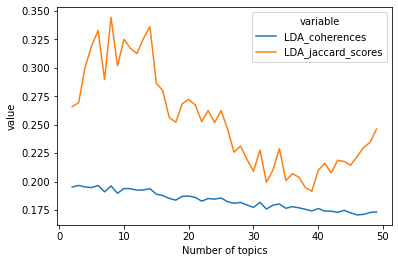

In [40]:
LDA = pd.DataFrame(list(zip([*range(kmin,kmax)], LDA_coherences, LDA_jaccard_scores)), 
                  columns = ['num_topics', 'LDA_coherences', 'LDA_jaccard_scores'])
sns.lineplot(x = 'num_topics',
             y = 'value',
             hue = 'variable',
             data = pd.melt(LDA, ['num_topics']))
plt.xlabel('Number of topics')
plt.show()

In [41]:
zip_object = zip(LDA_jaccard_scores, LDA_coherences)
LDA_diff = []
#loop to find diff of each element
for list1_i, list2_i in zip_object:
    LDA_diff.append(list1_i - list2_i)
pd.DataFrame(zip([*range(kmin,kmax)], LDA_diff))

0         1
0    2  0.070634
1    3  0.072774
2    4  0.105425
3    5  0.124422
4    6  0.136215
5    7  0.098594
6    8  0.148303
7    9  0.112007
8   10  0.131183
9   11  0.123301
10  12  0.120074
11  13  0.133117
12  14  0.142398
13  15  0.097583
14  16  0.092064
15  17  0.070971
16  18  0.068448
17  19  0.081356
18  20  0.084934
19  21  0.081395
20  22  0.069981
21  23  0.077353
22  24  0.067375
23  25  0.076746
24  26  0.063729
25  27  0.044872
26  28  0.049642
27  29  0.040124
28  30  0.031684
29  31  0.045894
30  32  0.023451
31  33  0.030830
32  34  0.048734
33  35  0.024394
34  36  0.028940
35  37  0.026972
36  38  0.019223
37  39  0.017235
38  40  0.033622
39  41  0.042000
40  42  0.033661
41  43  0.045780
42  44  0.043002
43  45  0.041894
44  46  0.051356
45  47  0.058710
46  48  0.061604
47  49  0.072824

In [44]:
pd.DataFrame(zip([*range(kmin,kmax)], LDA_diff))[pd.DataFrame(zip([*range(kmin,kmax)], LDA_diff))[1]==min(pd.DataFrame(zip([*range(kmin,kmax)], LDA_diff))[1])]

0         1
37  39  0.017235

## LDA model

In [29]:
LDA_model = LDA(17) 
LDA_transform = LDA_model.fit_transform(data_vectorized)
LDA_components = LDA_model.components_  

In [30]:
term_rankings = []
for topic_index in range(14):
    term_rankings.append( get_descriptor( data_vectorized.columns, LDA_components, topic_index, 100 ) )

In [31]:
LDA_coherence = calculate_coherence( w2v_model, term_rankings )
LDA_coherence

0.18411631148498006

In [32]:
jaccards = []
for j in list(combinations([*range(0,len(term_rankings))],2)):
    t1 = term_rankings[j[0]]
    t2 = term_rankings[j[1]]
    jaccards.append(jaccard_similarity(set(t1), set(t2)))
LDA_jaccard = sum(jaccards)/len(jaccards)
LDA_jaccard

0.2512313461304286

In [33]:
LDA_model.perplexity(data_vectorized)

914.2086247627366

In [22]:
term_rankings

[['class',
  'time',
  'think',
  'day',
  'thing',
  'really',
  'feel',
  'good',
  'year',
  'work',
  'also',
  'office',
  'even',
  'way',
  'want',
  'semester',
  'something',
  'well',
  'going',
  'much',
  'got',
  'need',
  'school',
  'teaching',
  'never',
  'said',
  'first',
  'right',
  'life',
  'help',
  'hour',
  'someone',
  'always',
  'love',
  'week',
  'lot',
  'course',
  'back',
  'talk',
  'thank',
  'still',
  'tell',
  'meeting',
  'sure',
  'kid',
  'look',
  'thought',
  'actually',
  'post',
  'bad',
  'teach',
  'great',
  'person',
  'job',
  'made',
  'colleague',
  'anything',
  'email',
  'mean',
  'friend',
  'question',
  'ask',
  'care',
  'better',
  'many',
  'last',
  'try',
  'maybe',
  'prof',
  'sometimes',
  'gt',
  'lecture',
  'hard',
  'nice',
  'faculty',
  'kind',
  'old',
  'teacher',
  'best',
  'guy',
  'today',
  'little',
  'read',
  'oh',
  'point',
  'new',
  'everyone',
  'issue',
  'grade',
  'ever',
  'sorry',
  'pretty',
 

# NMF

## Finding optimum number of topics

In [ ]:
kmin, kmax = 2, 50

NMF_topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    # run NMF
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform(data_vectorized)
    H = model.components_    
    # store for later
    NMF_topic_models.append( (k,W,H) )

C:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
C:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
C:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
C:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
C:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
C:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
C:\Anaconda\lib\

In [ ]:
NMF_k_values = []
NMF_coherences = []
for (k,W,H) in NMF_topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 100 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( data_vectorized.columns, H, topic_index, 100 ) )
    # Now calculate the coherence based on our Word2vec model
    NMF_k_values.append( k )
    NMF_coherences.append( calculate_coherence( w2v_model, term_rankings ) )

In [ ]:
NMF_jaccard_scores = []
for (k,W,H) in NMF_topic_models:
    jaccards = []
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( data_vectorized.columns, H, topic_index, 100 ) )
    for j in list(combinations([*range(0,len(term_rankings))],2)):
        t1 = term_rankings[j[0]]
        t2 = term_rankings[j[1]]
        jaccards.append(jaccard_similarity(set(t1), set(t2)))
    mean = sum(jaccards)/len(jaccards)
    NMF_jaccard_scores.append(mean)

In [49]:
NMF_coherences

[0.19955930115786769,
 0.19752072893647532,
 0.19371284333217625,
 0.19278457951161898,
 0.19093903765239148,
 0.18732216023241977,
 0.18606112621649348,
 0.18323884921990893,
 0.18208072455470084,
 0.18179184335707263,
 0.1814481953024921,
 0.17905177325314228,
 0.17804612203136963,
 0.17758270814475485,
 0.17711164352585174,
 0.17685913573327436,
 0.17616423734893352,
 0.17699423537969863,
 0.1755951329874571,
 0.1756221473799188,
 0.1750227569981116,
 0.17482506383783442,
 0.17473677664460543,
 0.1742857734111223,
 0.17400817932472754,
 0.1742311688277311,
 0.1725041200111191,
 0.1729628033342034,
 0.17219948921311232,
 0.17169165314056534,
 0.17191695425792003,
 0.17165443238827344,
 0.17160525779298766,
 0.1716419186548264,
 0.1703101395355228,
 0.1707025983363162,
 0.17028296637279516,
 0.16925566177648763,
 0.16973431609748305,
 0.16926348624110357,
 0.16936914002287867,
 0.16878036645376282,
 0.16879774873371775,
 0.16869378249333414,
 0.16823357745419557,
 0.16762512462174603,

In [50]:
NMF_jaccard_scores

[0.22699386503067484,
 0.2501302286815648,
 0.23620763035600545,
 0.23883697342762913,
 0.20923700081996943,
 0.20683868417264425,
 0.1815610048770268,
 0.17787295394360025,
 0.1720064466985727,
 0.16554563654319387,
 0.16296146892323268,
 0.15290125776618693,
 0.15291222538167826,
 0.15188777285584376,
 0.1519948265281004,
 0.1534375565652894,
 0.1530057008872443,
 0.1536713005459193,
 0.1514071034353517,
 0.15176770007991278,
 0.1505795616595546,
 0.15107611174959357,
 0.14815906192338082,
 0.14771472681442774,
 0.14922411565512012,
 0.15015488901260945,
 0.14584073584907506,
 0.1478962989702305,
 0.14369196496523357,
 0.1435071295518823,
 0.14743661605274003,
 0.14455939030868678,
 0.14564570843443372,
 0.1446062130250972,
 0.1415008688910265,
 0.1431687784322136,
 0.14392376427983797,
 0.1392200184514424,
 0.13884946555060027,
 0.14065740375280694,
 0.14188647999085313,
 0.13973236359923732,
 0.13840031085623428,
 0.1408704885711681,
 0.13817118870114486,
 0.13714976850815744,
 0.1

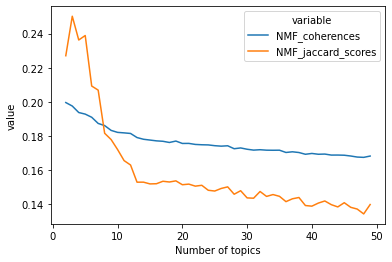

In [51]:
NMF = pd.DataFrame(list(zip([*range(kmin,kmax)], NMF_coherences, NMF_jaccard_scores)), 
                  columns = ['num_topics', 'NMF_coherences', 'NMF_jaccard_scores'])
sns.lineplot(x = 'num_topics',
             y = 'value',
             hue = 'variable',
             data = pd.melt(NMF, ['num_topics']))
plt.xlabel('Number of topics')
plt.show()

In [52]:
zip_object = zip(NMF_jaccard_scores, NMF_coherences)
NMF_diff = []
#loop to find diff of each element
for list1_i, list2_i in zip_object:
    NMF_diff.append(abs(list1_i - list2_i))
pd.DataFrame(zip([*range(kmin,kmax)], NMF_diff))

0         1
0    2  0.027435
1    3  0.052609
2    4  0.042495
3    5  0.046052
4    6  0.018298
5    7  0.019517
6    8  0.004500
7    9  0.005366
8   10  0.010074
9   11  0.016246
10  12  0.018487
11  13  0.026151
12  14  0.025134
13  15  0.025695
14  16  0.025117
15  17  0.023422
16  18  0.023159
17  19  0.023323
18  20  0.024188
19  21  0.023854
20  22  0.024443
21  23  0.023749
22  24  0.026578
23  25  0.026571
24  26  0.024784
25  27  0.024076
26  28  0.026663
27  29  0.025067
28  30  0.028508
29  31  0.028185
30  32  0.024480
31  33  0.027095
32  34  0.025960
33  35  0.027036
34  36  0.028809
35  37  0.027534
36  38  0.026359
37  39  0.030036
38  40  0.030885
39  41  0.028606
40  42  0.027483
41  43  0.029048
42  44  0.030397
43  45  0.027823
44  46  0.030062
45  47  0.030475
46  48  0.033136
47  49  0.028409

In [53]:
pd.DataFrame(zip([*range(kmin,kmax)], NMF_diff))[pd.DataFrame(zip([*range(kmin,kmax)], NMF_diff))[1]==min(pd.DataFrame(zip([*range(kmin,kmax)], NMF_diff))[1])]

0       1
6  8  0.0045

## NMF model

In [11]:
NMF_model = NMF(8) 
NMF_transform = NMF_model.fit_transform(data_vectorized)
NMF_components = NMF_model.components_    

/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [36]:
term_rankings = []
for topic_index in range(8):
    term_rankings.append( get_descriptor( data_vectorized.columns, NMF_components, topic_index, 100 ) )
NMF_coherence = calculate_coherence( w2v_model, term_rankings )
NMF_coherence

0.18533689921444305

In [37]:
jaccards = []
for j in list(combinations([*range(0,len(term_rankings))],2)):
    t1 = term_rankings[j[0]]
    t2 = term_rankings[j[1]]
    jaccards.append(jaccard_similarity(set(t1), set(t2)))
NMF_jaccard = sum(jaccards)/len(jaccards)
NMF_jaccard

0.1815610048770268

In [43]:
term_rankings

[['think',
  'thing',
  'really',
  'even',
  'feel',
  'good',
  'way',
  'time',
  'also',
  'want',
  'something',
  'work',
  'school',
  'need',
  'much',
  'someone',
  'going',
  'right',
  'gt',
  'year',
  'well',
  'life',
  'said',
  'never',
  'post',
  'help',
  'got',
  'issue',
  'bad',
  'lot',
  'person',
  'mean',
  'always',
  'better',
  'actually',
  'sure',
  'many',
  'office',
  'still',
  'point',
  'maybe',
  'talk',
  'kid',
  'care',
  'tell',
  'back',
  'day',
  'problem',
  'look',
  'thought',
  'best',
  'first',
  'teacher',
  'hard',
  'anything',
  'kind',
  'made',
  'friend',
  'probably',
  'thank',
  'try',
  'ask',
  'deleted',
  'situation',
  'prof',
  'colleague',
  'pretty',
  'everyone',
  'health',
  'love',
  'call',
  'sound',
  'saying',
  'ever',
  'reason',
  'great',
  'understand',
  'idea',
  'getting',
  'little',
  'trying',
  'wrong',
  'case',
  'sorry',
  'place',
  'family',
  'sometimes',
  'world',
  'story',
  'name',
  'h

# BTM

## Finding optimum number of topics

In [ ]:
min_posts = pd.DataFrame(posts_clean['lemmatized'])
min_posts.reset_index(inplace=True)
min_posts = min_posts.rename(columns = {'index':'post_index'})
min_posts.lemmatized = min_posts['lemmatized'].apply(set)
min_posts.lemmatized = min_posts['lemmatized'].apply(list)
min_posts.head()

post_index                                         lemmatized
0           0  [disability, created, work, new, program, offe...
1           1  [pay, scholar, comment, cherokee, thrive, post...
2           2  [pop, cut, time, theme, trying, end, uploaded,...
3           3  [posting, le, breaking, report, told, universi...
4           4  [drop, bad, seen, nothing, faith, responsibili...

In [ ]:
words_to_remove = pd.read_csv('words_to_remove.csv', encoding = "UTF-8")
words_to_remove 

word
0               aa
1              aaa
2             aaaa
3            aaaaa
4      aaaaaaaaaaa
...            ...
63901          zzz
63902      zzzquil
63903         zzzs
63904      zzzxxxx
63905     zzzzzzzz

[63906 rows x 1 columns]

In [ ]:
def shorter_text(wordlist):
    string = ""
    for word in wordlist:
        if word not in words_to_remove['word'].tolist():
            string = string + " " + word
    return string

In [ ]:
min_posts['shorter'] = min_posts['lemmatized'].apply(shorter_text)
min_posts

post_index                                         lemmatized  \
0               0  [disability, created, work, new, program, offe...   
1               1  [pay, scholar, comment, cherokee, thrive, post...   
2               2  [pop, cut, time, theme, trying, end, uploaded,...   
3               3  [posting, le, breaking, report, told, universi...   
4               4  [drop, bad, seen, nothing, faith, responsibili...   
...           ...                                                ...   
16454       16454  [relevant, le, emotional, downright, truly, to...   
16455       16455  [opportunity, chair, wrote, distracted, report...   
16456       16456  [away, overhead, advisor, education, le, scien...   
16457       16457  [relevant, helpful, grad, gone, skype, city, u...   
16458       16458              [winning, removed, karl, award, kjer]   

                                                 shorter  
0            disability created new program offer social  
1       pay scholar comment posted continued academic...  
2       pop cut theme trying end uploaded slide essay...  
3       posting le breaking report told university no...  
4       drop bad seen nothing faith responsibility ma...  
...                                                  ...  
16454   relevant le emotional truly told school episo...  
16455   opportunity chair wrote distracted report fal...  
16456   away advisor education le science told school...  
16457   relevant helpful grad gone city university sc...  
16458                              winning removed award  

[16459 rows x 3 columns]

In [ ]:
pd.DataFrame(min_posts).to_csv('min_posts.csv')

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/amycfarrow/TM/main/min_posts.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

In [8]:
df

post_index  ... Unnamed: 605
0              0  ...          NaN
1              1  ...          NaN
2              2  ...          NaN
3              3  ...          NaN
4              4  ...          NaN
...          ...  ...          ...
16455      16454  ...          NaN
16456      16455  ...          NaN
16457      16456  ...          NaN
16458      16457  ...          NaN
16459      16458  ...          NaN

[16460 rows x 606 columns]

In [ ]:
min_posts = pd.read_csv('min_posts.csv', encoding = "UTF-8")
min_posts

Unnamed: 0  post_index  \
0               0           0   
1               1           1   
2               2           2   
3               3           3   
4               4           4   
...           ...         ...   
16454       16454       16454   
16455       16455       16455   
16456       16456       16456   
16457       16457       16457   
16458       16458       16458   

                                              lemmatized  \
0      ['disability', 'created', 'work', 'new', 'prog...   
1      ['pay', 'scholar', 'comment', 'cherokee', 'thr...   
2      ['pop', 'cut', 'time', 'theme', 'trying', 'end...   
3      ['posting', 'le', 'breaking', 'report', 'told'...   
4      ['drop', 'bad', 'seen', 'nothing', 'faith', 'r...   
...                                                  ...   
16454  ['relevant', 'le', 'emotional', 'downright', '...   
16455  ['opportunity', 'chair', 'wrote', 'distracted'...   
16456  ['away', 'overhead', 'advisor', 'education', '...   
16457  ['relevant', 'helpful', 'grad', 'gone', 'skype...   
16458    ['winning', 'removed', 'karl', 'award', 'kjer']   

                                                 shorter  
0            disability created new program offer social  
1       pay scholar comment posted continued academic...  
2       pop cut theme trying end uploaded slide essay...  
3       posting le breaking report told university no...  
4       drop bad seen nothing faith responsibility ma...  
...                                                  ...  
16454   relevant le emotional truly told school episo...  
16455   opportunity chair wrote distracted report fal...  
16456   away advisor education le science told school...  
16457   relevant helpful grad gone city university sc...  
16458                              winning removed award  

[16459 rows x 4 columns]

In [5]:
min_posts = df[~df['shorter'].isnull().values]
min_posts

post_index  ... Unnamed: 605
0              0  ...          NaN
1              1  ...          NaN
2              2  ...          NaN
3              3  ...          NaN
4              4  ...          NaN
...          ...  ...          ...
16455      16454  ...          NaN
16456      16455  ...          NaN
16457      16456  ...          NaN
16458      16457  ...          NaN
16459      16458  ...          NaN

[16416 rows x 606 columns]

In [6]:
texts = min_posts['shorter'].str.strip().tolist()

In [7]:
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)

In [8]:
tf = np.array(X.sum(axis=0)).ravel()

In [9]:
# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))

In [10]:
# Generating biterms
biterms = btm.get_biterms(docs_vec)

In [32]:
kmin = 2
kmax = 50

BTM_coherences = []
BTM_jaccard_scores = []
for k in range(kmin,kmax+1):
    model = btm.BTM(X, vocabulary, seed=12321, T=k, M=20, alpha=50/8, beta=0.01)
    model.fit(biterms, iterations=20)
    coherence = model.coherence_
    BTM_coherences.append(sum(coherence)/len(coherence))
    phi = tmp.get_phi(model)
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( list(tmp.calc_terms_probs_ratio(phi, topic=topic_index, lambda_=1)['Terms']) )
    jaccards = []
    for j in list(combinations([*range(0,len(term_rankings))],2)):
        t1 = term_rankings[j[0]]
        t2 = term_rankings[j[1]]
        jaccards.append(jaccard_similarity(set(t1), set(t2)))
    BTM_jaccard_scores.append(sum(jaccards)/len(jaccards))

Audio(url="http://www.nch.com.au/acm/8k16bitpcm.wav", autoplay = True)

100%|██████████| 20/20 [07:07<00:00, 21.37s/it]


In [33]:
BTM_jaccard_scores

[0.0,
 0.0,
 0.005649717514124294,
 0.006838106370543541,
 0.004558737580362362,
 0.003228410008071025,
 0.004279034816732069,
 0.00813535397035351,
 0.005391327529812257,
 0.002465331278890601,
 0.003905678334298102,
 0.004623571697305125,
 0.0031987760616755674,
 0.0049442718426692105,
 0.0045239869638497715,
 0.006310616551129133,
 0.007891339355967942,
 0.005693931878745476,
 0.006888405544695453,
 0.00808450982194699,
 0.007090662755401925,
 0.0078834125707547,
 0.008671470869707711,
 0.007865288918616965,
 0.01005684051502557,
 0.009496259428315843,
 0.010901193293592943,
 0.009558216745809997,
 0.011433204087555942,
 0.01018276139205852,
 0.012414916391396026,
 0.011435992339598603,
 0.0146449114100512,
 0.012335464424450136,
 0.012530410177248,
 0.014518347209522489,
 0.013613006529684514,
 0.013813047852189446,
 0.018115262930738254,
 0.016725791225612473,
 0.016098568807818237,
 0.016540741513582126,
 0.01747265174650373,
 0.01647719031593214,
 0.018737028532848178,
 0.017839

In [34]:
BTM_coherences

[-111.36295373371394,
 -123.977191324559,
 -133.0283341027766,
 -135.5900552103863,
 -156.71231792883808,
 -160.3634731565335,
 -165.36384972694466,
 -164.92232510611254,
 -179.07812783089815,
 -186.38964570711138,
 -191.62854141864128,
 -187.08111179178397,
 -193.51311675037633,
 -200.10866312064374,
 -205.59413843382782,
 -200.40544384005372,
 -204.386463349274,
 -214.51782703347584,
 -214.29696263070628,
 -218.209758233936,
 -215.87400266564362,
 -216.23800210582016,
 -219.0311784650248,
 -224.66080826553082,
 -220.7985359578044,
 -222.22710728918125,
 -223.21672791237057,
 -230.1123591866203,
 -223.95090021948988,
 -228.48923385661806,
 -229.22370412815144,
 -228.05395348110252,
 -223.33796212677098,
 -232.37491921327629,
 -230.70938635965982,
 -225.52684033423597,
 -231.804802538698,
 -231.69020963221695,
 -218.01995875219782,
 -229.36104102887177,
 -228.2164156609481,
 -229.91341508502512,
 -226.82109774032514,
 -228.45437916097774,
 -224.29824333216888,
 -231.36010011255306,
 -2

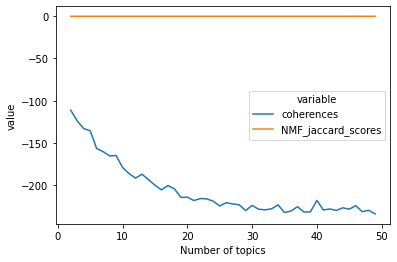

In [35]:
BTM = pd.DataFrame(list(zip([*range(kmin,kmax)], BTM_coherences, BTM_jaccard_scores)), 
                  columns = ['num_topics', 'coherences', 'NMF_jaccard_scores'])
sns.lineplot(x = 'num_topics',
             y = 'value',
             hue = 'variable',
             data = pd.melt(BTM, ['num_topics']))
plt.xlabel('Number of topics')
plt.show()

In [38]:
model = btm.BTM(
    X, vocabulary, seed=12321, T=15, M=20, alpha=50/8, beta=0.01)

In [39]:
model.fit(biterms, iterations=20)

100%|██████████| 20/20 [02:15<00:00,  6.78s/it]


In [12]:
import tmplot as tmp

In [41]:
# Get a phi matrix
phi = tmp.get_phi(model)

# Calculate terms probabilities
# Do not forget to pass topic id with `topic` argument
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=0, lambda_=1)
terms_probs

Terms                                  Type  Probability
0           ask       Marginal term probability, p(w)     0.028719
1      semester       Marginal term probability, p(w)     0.036455
2          life       Marginal term probability, p(w)     0.022463
3      learning       Marginal term probability, p(w)     0.019772
4           day       Marginal term probability, p(w)     0.035785
5        matter       Marginal term probability, p(w)     0.016875
6          went       Marginal term probability, p(w)     0.016401
7         extra       Marginal term probability, p(w)     0.016483
8         often       Marginal term probability, p(w)     0.021394
9         write       Marginal term probability, p(w)     0.020791
10         mind       Marginal term probability, p(w)     0.016550
11         word       Marginal term probability, p(w)     0.019189
12      process       Marginal term probability, p(w)     0.013424
13      learned       Marginal term probability, p(w)     0.011654
14        chair       Marginal term probability, p(w)     0.011417
15       review       Marginal term probability, p(w)     0.012021
16         side       Marginal term probability, p(w)     0.010996
17         rule       Marginal term probability, p(w)     0.011917
18   especially       Marginal term probability, p(w)     0.016291
19      require       Marginal term probability, p(w)     0.011096
20  opportunity       Marginal term probability, p(w)     0.010102
21         live       Marginal term probability, p(w)     0.010670
22      current       Marginal term probability, p(w)     0.012630
23   instructor       Marginal term probability, p(w)     0.013256
24       reason       Marginal term probability, p(w)     0.020411
25       easier       Marginal term probability, p(w)     0.012638
26     expected       Marginal term probability, p(w)     0.008892
27       access       Marginal term probability, p(w)     0.009255
28         miss       Marginal term probability, p(w)     0.008096
29        using       Marginal term probability, p(w)     0.020960
30          ask  Conditional term probability, p(w|t)     0.022735
31     semester  Conditional term probability, p(w|t)     0.016714
32         life  Conditional term probability, p(w|t)     0.016571
33     learning  Conditional term probability, p(w|t)     0.016293
34          day  Conditional term probability, p(w|t)     0.015296
35       matter  Conditional term probability, p(w|t)     0.015277
36         went  Conditional term probability, p(w|t)     0.014887
37        extra  Conditional term probability, p(w|t)     0.014122
38        often  Conditional term probability, p(w|t)     0.014067
39        write  Conditional term probability, p(w|t)     0.014024
40         mind  Conditional term probability, p(w|t)     0.014007
41         word  Conditional term probability, p(w|t)     0.013842
42      process  Conditional term probability, p(w|t)     0.011164
43      learned  Conditional term probability, p(w|t)     0.010695
44        chair  Conditional term probability, p(w|t)     0.010655
45       review  Conditional term probability, p(w|t)     0.010617
46         side  Conditional term probability, p(w|t)     0.010561
47         rule  Conditional term probability, p(w|t)     0.010174
48   especially  Conditional term probability, p(w|t)     0.009973
49      require  Conditional term probability, p(w|t)     0.009766
50  opportunity  Conditional term probability, p(w|t)     0.009670
51         live  Conditional term probability, p(w|t)     0.009641
52      current  Conditional term probability, p(w|t)     0.009449
53   instructor  Conditional term probability, p(w|t)     0.008995
54       reason  Conditional term probability, p(w|t)     0.008826
55       easier  Conditional term probability, p(w|t)     0.008803
56     expected  Conditional term probability, p(w|t)     0.008548
57       access  Conditional term probability, p(w|t)     0.008416
58         miss  Conditional term probability, p(w|t)    

In [42]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=1, lambda_=1)
terms_probs

Terms                                  Type  Probability
0   university       Marginal term probability, p(w)     0.032375
1         idea       Marginal term probability, p(w)     0.031912
2          use       Marginal term probability, p(w)     0.032945
3        still       Marginal term probability, p(w)     0.037314
4        whole       Marginal term probability, p(w)     0.021445
5         term       Marginal term probability, p(w)     0.025008
6      similar       Marginal term probability, p(w)     0.021409
7          big       Marginal term probability, p(w)     0.018400
8        world       Marginal term probability, p(w)     0.016112
9     required       Marginal term probability, p(w)     0.017330
10        stop       Marginal term probability, p(w)     0.016591
11        grad       Marginal term probability, p(w)     0.016716
12        week       Marginal term probability, p(w)     0.031590
13       today       Marginal term probability, p(w)     0.016110
14         due       Marginal term probability, p(w)     0.021877
15        many       Marginal term probability, p(w)     0.036044
16       topic       Marginal term probability, p(w)     0.016067
17        fail       Marginal term probability, p(w)     0.012917
18     deleted       Marginal term probability, p(w)     0.013083
19     telling       Marginal term probability, p(w)     0.012245
20      report       Marginal term probability, p(w)     0.011992
21       board       Marginal term probability, p(w)     0.010964
22      posted       Marginal term probability, p(w)     0.012245
23       wrote       Marginal term probability, p(w)     0.010723
24        suck       Marginal term probability, p(w)     0.010629
25     certain       Marginal term probability, p(w)     0.013382
26   knowledge       Marginal term probability, p(w)     0.009953
27      tenure       Marginal term probability, p(w)     0.011692
28        stay       Marginal term probability, p(w)     0.010914
29        took       Marginal term probability, p(w)     0.016982
30  university  Conditional term probability, p(w|t)     0.023625
31        idea  Conditional term probability, p(w|t)     0.022829
32         use  Conditional term probability, p(w|t)     0.019533
33       still  Conditional term probability, p(w|t)     0.018350
34       whole  Conditional term probability, p(w|t)     0.017285
35        term  Conditional term probability, p(w|t)     0.016597
36     similar  Conditional term probability, p(w|t)     0.014948
37         big  Conditional term probability, p(w|t)     0.013971
38       world  Conditional term probability, p(w|t)     0.013323
39    required  Conditional term probability, p(w|t)     0.013285
40        stop  Conditional term probability, p(w|t)     0.013205
41        grad  Conditional term probability, p(w|t)     0.013193
42        week  Conditional term probability, p(w|t)     0.012585
43       today  Conditional term probability, p(w|t)     0.011635
44         due  Conditional term probability, p(w|t)     0.011522
45        many  Conditional term probability, p(w|t)     0.011342
46       topic  Conditional term probability, p(w|t)     0.011020
47        fail  Conditional term probability, p(w|t)     0.010761
48     deleted  Conditional term probability, p(w|t)     0.009943
49     telling  Conditional term probability, p(w|t)     0.009928
50      report  Conditional term probability, p(w|t)     0.009685
51       board  Conditional term probability, p(w|t)     0.009081
52      posted  Conditional term probability, p(w|t)     0.009050
53       wrote  Conditional term probability, p(w|t)     0.008951
54        suck  Conditional term probability, p(w|t)     0.008845
55     certain  Conditional term probability, p(w|t)     0.008816
56   knowledge  Conditional term probability, p(w|t)     0.008186
57      tenure  Conditional term probability, p(w|t)     0.008012
58        stay  Conditional term probability, p(w|t)     0.007860
59        took  Conditional term probability, p(w

In [43]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=2, lambda_=1)
terms_probs

Terms                                  Type  Probability
0         next       Marginal term probability, p(w)     0.025491
1         show       Marginal term probability, p(w)     0.021593
2     research       Marginal term probability, p(w)     0.019872
3    professor       Marginal term probability, p(w)     0.024420
4        given       Marginal term probability, p(w)     0.019120
5       saying       Marginal term probability, p(w)     0.018948
6         read       Marginal term probability, p(w)     0.023687
7      writing       Marginal term probability, p(w)     0.018730
8      thought       Marginal term probability, p(w)     0.025165
9       better       Marginal term probability, p(w)     0.030741
10        came       Marginal term probability, p(w)     0.012796
11      taught       Marginal term probability, p(w)     0.015221
12     comment       Marginal term probability, p(w)     0.013529
13        fair       Marginal term probability, p(w)     0.013038
14       offer       Marginal term probability, p(w)     0.013166
15  completely       Marginal term probability, p(w)     0.013982
16       level       Marginal term probability, p(w)     0.019208
17        dean       Marginal term probability, p(w)     0.011772
18     explain       Marginal term probability, p(w)     0.012089
19  particular       Marginal term probability, p(w)     0.010555
20        sent       Marginal term probability, p(w)     0.011159
21   seriously       Marginal term probability, p(w)     0.010730
22       close       Marginal term probability, p(w)     0.010410
23      simply       Marginal term probability, p(w)     0.012763
24       order       Marginal term probability, p(w)     0.009900
25   attention       Marginal term probability, p(w)     0.008951
26       covid       Marginal term probability, p(w)     0.010539
27        mine       Marginal term probability, p(w)     0.013865
28       spent       Marginal term probability, p(w)     0.008523
29    academia       Marginal term probability, p(w)     0.009388
30        next  Conditional term probability, p(w|t)     0.019299
31        show  Conditional term probability, p(w|t)     0.016148
32    research  Conditional term probability, p(w|t)     0.015151
33   professor  Conditional term probability, p(w|t)     0.015120
34       given  Conditional term probability, p(w|t)     0.015089
35      saying  Conditional term probability, p(w|t)     0.013590
36        read  Conditional term probability, p(w|t)     0.012401
37     writing  Conditional term probability, p(w|t)     0.012206
38     thought  Conditional term probability, p(w|t)     0.011752
39      better  Conditional term probability, p(w|t)     0.011660
40        came  Conditional term probability, p(w|t)     0.011317
41      taught  Conditional term probability, p(w|t)     0.011316
42     comment  Conditional term probability, p(w|t)     0.011221
43        fair  Conditional term probability, p(w|t)     0.011026
44       offer  Conditional term probability, p(w|t)     0.010261
45  completely  Conditional term probability, p(w|t)     0.010191
46       level  Conditional term probability, p(w|t)     0.010003
47        dean  Conditional term probability, p(w|t)     0.009901
48     explain  Conditional term probability, p(w|t)     0.009732
49  particular  Conditional term probability, p(w|t)     0.009300
50        sent  Conditional term probability, p(w|t)     0.009279
51   seriously  Conditional term probability, p(w|t)     0.009169
52       close  Conditional term probability, p(w|t)     0.008994
53      simply  Conditional term probability, p(w|t)     0.008763
54       order  Conditional term probability, p(w|t)     0.008751
55   attention  Conditional term probability, p(w|t)     0.008070
56       covid  Conditional term probability, p(w|t)     0.007746
57        mine  Conditional term probability, p(w|t)     0.007675
58       spent  Conditional term probability, p(w|t)     0.007136
59    academia  Conditional term probability, p(w

In [44]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=3, lambda_=1)
terms_probs

Terms                                  Type  Probability
0         first       Marginal term probability, p(w)     0.038580
1         point       Marginal term probability, p(w)     0.034022
2          look       Marginal term probability, p(w)     0.029138
3          feel       Marginal term probability, p(w)     0.032833
4          last       Marginal term probability, p(w)     0.029381
5       started       Marginal term probability, p(w)     0.017902
6          turn       Marginal term probability, p(w)     0.017018
7          seem       Marginal term probability, p(w)     0.016992
8          seen       Marginal term probability, p(w)     0.016095
9        wanted       Marginal term probability, p(w)     0.016547
10        clear       Marginal term probability, p(w)     0.015919
11         said       Marginal term probability, p(w)     0.026181
12        sense       Marginal term probability, p(w)     0.014959
13        great       Marginal term probability, p(w)     0.022723
14         else       Marginal term probability, p(w)     0.021967
15         sort       Marginal term probability, p(w)     0.015735
16        quite       Marginal term probability, p(w)     0.015051
17       friend       Marginal term probability, p(w)     0.014638
18          kid       Marginal term probability, p(w)     0.014095
19        state       Marginal term probability, p(w)     0.014857
20        happy       Marginal term probability, p(w)     0.013231
21    classroom       Marginal term probability, p(w)     0.012821
22         hand       Marginal term probability, p(w)     0.015609
23     standard       Marginal term probability, p(w)     0.011897
24     decision       Marginal term probability, p(w)     0.010202
25         math       Marginal term probability, p(w)     0.010114
26           oh       Marginal term probability, p(w)     0.016011
27      program       Marginal term probability, p(w)     0.014877
28       mostly       Marginal term probability, p(w)     0.011978
29  requirement       Marginal term probability, p(w)     0.009637
30        first  Conditional term probability, p(w|t)     0.025708
31        point  Conditional term probability, p(w|t)     0.023680
32         look  Conditional term probability, p(w|t)     0.020089
33         feel  Conditional term probability, p(w|t)     0.018856
34         last  Conditional term probability, p(w|t)     0.018263
35      started  Conditional term probability, p(w|t)     0.013292
36         turn  Conditional term probability, p(w|t)     0.013075
37         seem  Conditional term probability, p(w|t)     0.012799
38         seen  Conditional term probability, p(w|t)     0.012377
39       wanted  Conditional term probability, p(w|t)     0.012303
40        clear  Conditional term probability, p(w|t)     0.011953
41         said  Conditional term probability, p(w|t)     0.011601
42        sense  Conditional term probability, p(w|t)     0.011448
43        great  Conditional term probability, p(w|t)     0.011279
44         else  Conditional term probability, p(w|t)     0.011219
45         sort  Conditional term probability, p(w|t)     0.011176
46        quite  Conditional term probability, p(w|t)     0.010887
47       friend  Conditional term probability, p(w|t)     0.010457
48          kid  Conditional term probability, p(w|t)     0.010073
49        state  Conditional term probability, p(w|t)     0.009858
50        happy  Conditional term probability, p(w|t)     0.009678
51    classroom  Conditional term probability, p(w|t)     0.009529
52         hand  Conditional term probability, p(w|t)     0.009146
53     standard  Conditional term probability, p(w|t)     0.009117
54     decision  Conditional term probability, p(w|t)     0.007649
55         math  Conditional term probability, p(w|t)     0.007546
56           oh  Conditional term probability, p(w|t)     0.007262
57      program  Conditional term probability, p(w|t)     0.007262
58       mostly  Conditional term probability, p(w|t)    

In [45]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=4, lambda_=1)
terms_probs

Terms                                  Type  Probability
0           going       Marginal term probability, p(w)     0.039730
1       different       Marginal term probability, p(w)     0.029803
2            post       Marginal term probability, p(w)     0.026791
3            able       Marginal term probability, p(w)     0.024174
4         problem       Marginal term probability, p(w)     0.027524
5            exam       Marginal term probability, p(w)     0.021029
6            real       Marginal term probability, p(w)     0.019256
7            hope       Marginal term probability, p(w)     0.018335
8            type       Marginal term probability, p(w)     0.016904
9      discussion       Marginal term probability, p(w)     0.015716
10           week       Marginal term probability, p(w)     0.031590
11          still       Marginal term probability, p(w)     0.037314
12       personal       Marginal term probability, p(w)     0.014036
13     personally       Marginal term probability, p(w)     0.012892
14           rest       Marginal term probability, p(w)     0.012892
15           past       Marginal term probability, p(w)     0.016108
16            low       Marginal term probability, p(w)     0.013278
17            non       Marginal term probability, p(w)     0.015840
18          asked       Marginal term probability, p(w)     0.018869
19         simple       Marginal term probability, p(w)     0.009257
20           play       Marginal term probability, p(w)     0.009663
21        clearly       Marginal term probability, p(w)     0.013048
22          basic       Marginal term probability, p(w)     0.009701
23          money       Marginal term probability, p(w)     0.013204
24      mentioned       Marginal term probability, p(w)     0.008573
25           lost       Marginal term probability, p(w)     0.008695
26            use       Marginal term probability, p(w)     0.032945
27     considered       Marginal term probability, p(w)     0.008461
28         honest       Marginal term probability, p(w)     0.008347
29  unfortunately       Marginal term probability, p(w)     0.009654
30          going  Conditional term probability, p(w|t)     0.026679
31      different  Conditional term probability, p(w|t)     0.022301
32           post  Conditional term probability, p(w|t)     0.021786
33           able  Conditional term probability, p(w|t)     0.019200
34        problem  Conditional term probability, p(w|t)     0.017725
35           exam  Conditional term probability, p(w|t)     0.017291
36           real  Conditional term probability, p(w|t)     0.016561
37           hope  Conditional term probability, p(w|t)     0.016073
38           type  Conditional term probability, p(w|t)     0.014953
39     discussion  Conditional term probability, p(w|t)     0.013400
40           week  Conditional term probability, p(w|t)     0.012607
41          still  Conditional term probability, p(w|t)     0.012210
42       personal  Conditional term probability, p(w|t)     0.011868
43     personally  Conditional term probability, p(w|t)     0.011813
44           rest  Conditional term probability, p(w|t)     0.010950
45           past  Conditional term probability, p(w|t)     0.010686
46            low  Conditional term probability, p(w|t)     0.010365
47            non  Conditional term probability, p(w|t)     0.010169
48          asked  Conditional term probability, p(w|t)     0.010024
49         simple  Conditional term probability, p(w|t)     0.008344
50           play  Conditional term probability, p(w|t)     0.008094
51        clearly  Conditional term probability, p(w|t)     0.008034
52          basic  Conditional term probability, p(w|t)     0.007975
53          money  Conditional term probability, p(w|t)     0.007887
54      mentioned  Conditional term probability, p(w|t)     0.007881
55           lost  Conditional term probability, p(w|t)     0.007714
56            use  Conditional term probability, p(w|t)     0.007594
57     con

In [46]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=5, lambda_=1)
terms_probs

Terms                                  Type  Probability
0          sure       Marginal term probability, p(w)     0.037607
1       getting       Marginal term probability, p(w)     0.028572
2           put       Marginal term probability, p(w)     0.027240
3          used       Marginal term probability, p(w)     0.024913
4    experience       Marginal term probability, p(w)     0.023797
5        asking       Marginal term probability, p(w)     0.019825
6        better       Marginal term probability, p(w)     0.030741
7       content       Marginal term probability, p(w)     0.013904
8          move       Marginal term probability, p(w)     0.013531
9        likely       Marginal term probability, p(w)     0.017758
10           ok       Marginal term probability, p(w)     0.012770
11          lab       Marginal term probability, p(w)     0.012829
12         quiz       Marginal term probability, p(w)     0.010793
13        final       Marginal term probability, p(w)     0.017047
14       effort       Marginal term probability, p(w)     0.013232
15       couple       Marginal term probability, p(w)     0.016375
16  expectation       Marginal term probability, p(w)     0.009712
17      looking       Marginal term probability, p(w)     0.018773
18        story       Marginal term probability, p(w)     0.011650
19         step       Marginal term probability, p(w)     0.008964
20       paying       Marginal term probability, p(w)     0.007748
21        night       Marginal term probability, p(w)     0.007874
22      someone       Marginal term probability, p(w)     0.031072
23        meant       Marginal term probability, p(w)     0.007984
24    submitted       Marginal term probability, p(w)     0.007749
25     involved       Marginal term probability, p(w)     0.007104
26       handle       Marginal term probability, p(w)     0.007739
27       failed       Marginal term probability, p(w)     0.007360
28       nobody       Marginal term probability, p(w)     0.007760
29   reasonable       Marginal term probability, p(w)     0.008897
30         sure  Conditional term probability, p(w|t)     0.028659
31      getting  Conditional term probability, p(w|t)     0.022626
32          put  Conditional term probability, p(w|t)     0.020698
33         used  Conditional term probability, p(w|t)     0.019343
34   experience  Conditional term probability, p(w|t)     0.014891
35       asking  Conditional term probability, p(w|t)     0.014755
36       better  Conditional term probability, p(w|t)     0.012658
37      content  Conditional term probability, p(w|t)     0.012092
38         move  Conditional term probability, p(w|t)     0.011630
39       likely  Conditional term probability, p(w|t)     0.011449
40           ok  Conditional term probability, p(w|t)     0.011285
41          lab  Conditional term probability, p(w|t)     0.010520
42         quiz  Conditional term probability, p(w|t)     0.009601
43        final  Conditional term probability, p(w|t)     0.009402
44       effort  Conditional term probability, p(w|t)     0.009069
45       couple  Conditional term probability, p(w|t)     0.008964
46  expectation  Conditional term probability, p(w|t)     0.008864
47      looking  Conditional term probability, p(w|t)     0.008858
48        story  Conditional term probability, p(w|t)     0.008857
49         step  Conditional term probability, p(w|t)     0.008181
50       paying  Conditional term probability, p(w|t)     0.007105
51        night  Conditional term probability, p(w|t)     0.006957
52      someone  Conditional term probability, p(w|t)     0.006921
53        meant  Conditional term probability, p(w|t)     0.006652
54    submitted  Conditional term probability, p(w|t)     0.006613
55     involved  Conditional term probability, p(w|t)     0.006501
56       handle  Conditional term probability, p(w|t)     0.006483
57       failed  Conditional term probability, p(w|t)     0.006466
58       nobody  Conditional term probability, p(w|t)    

In [47]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=6, lambda_=1)
terms_probs

Terms                                  Type  Probability
0          teach       Marginal term probability, p(w)     0.026192
1       question       Marginal term probability, p(w)     0.027800
2       everyone       Marginal term probability, p(w)     0.022624
3         person       Marginal term probability, p(w)     0.023946
4     department       Marginal term probability, p(w)     0.019691
5     definitely       Marginal term probability, p(w)     0.015528
6          field       Marginal term probability, p(w)     0.014211
7           help       Marginal term probability, p(w)     0.025194
8        thought       Marginal term probability, p(w)     0.025165
9          going       Marginal term probability, p(w)     0.039730
10     situation       Marginal term probability, p(w)     0.014467
11       problem       Marginal term probability, p(w)     0.027524
12     sometimes       Marginal term probability, p(w)     0.015196
13        choice       Marginal term probability, p(w)     0.009821
14          read       Marginal term probability, p(w)     0.023687
15         asked       Marginal term probability, p(w)     0.018869
16       usually       Marginal term probability, p(w)     0.019151
17         first       Marginal term probability, p(w)     0.038580
18        giving       Marginal term probability, p(w)     0.010927
19            op       Marginal term probability, p(w)     0.008295
20          shit       Marginal term probability, p(w)     0.012027
21         level       Marginal term probability, p(w)     0.019208
22          felt       Marginal term probability, p(w)     0.008147
23           pay       Marginal term probability, p(w)     0.014217
24         point       Marginal term probability, p(w)     0.034022
25           guy       Marginal term probability, p(w)     0.009109
26          nice       Marginal term probability, p(w)     0.013356
27  conversation       Marginal term probability, p(w)     0.007946
28       example       Marginal term probability, p(w)     0.015857
29          feel       Marginal term probability, p(w)     0.032833
30         teach  Conditional term probability, p(w|t)     0.022135
31      question  Conditional term probability, p(w|t)     0.017767
32      everyone  Conditional term probability, p(w|t)     0.017486
33        person  Conditional term probability, p(w|t)     0.017455
34    department  Conditional term probability, p(w|t)     0.017225
35    definitely  Conditional term probability, p(w|t)     0.013114
36         field  Conditional term probability, p(w|t)     0.012353
37          help  Conditional term probability, p(w|t)     0.011620
38       thought  Conditional term probability, p(w|t)     0.009872
39         going  Conditional term probability, p(w|t)     0.009569
40     situation  Conditional term probability, p(w|t)     0.009502
41       problem  Conditional term probability, p(w|t)     0.009083
42     sometimes  Conditional term probability, p(w|t)     0.008946
43        choice  Conditional term probability, p(w|t)     0.008820
44          read  Conditional term probability, p(w|t)     0.008547
45         asked  Conditional term probability, p(w|t)     0.008303
46       usually  Conditional term probability, p(w|t)     0.008224
47         first  Conditional term probability, p(w|t)     0.007881
48        giving  Conditional term probability, p(w|t)     0.007760
49            op  Conditional term probability, p(w|t)     0.007477
50          shit  Conditional term probability, p(w|t)     0.007372
51         level  Conditional term probability, p(w|t)     0.007365
52          felt  Conditional term probability, p(w|t)     0.007318
53           pay  Conditional term probability, p(w|t)     0.007294
54         point  Conditional term probability, p(w|t)     0.007233
55           guy  Conditional term probability, p(w|t)     0.007158
56          nice  Conditional term probability, p(w|t)     0.007154
57  conversation  Conditional term probability, p(w|t)     0.006931

In [48]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=7, lambda_=1)
terms_probs

Terms                                  Type  Probability
0          got       Marginal term probability, p(w)     0.033235
1       enough       Marginal term probability, p(w)     0.026407
2          new       Marginal term probability, p(w)     0.025927
3     probably       Marginal term probability, p(w)     0.027878
4        guess       Marginal term probability, p(w)     0.016847
5        small       Marginal term probability, p(w)     0.016571
6     honestly       Marginal term probability, p(w)     0.014938
7        email       Marginal term probability, p(w)     0.024541
8          far       Marginal term probability, p(w)     0.018787
9         book       Marginal term probability, p(w)     0.014224
10        easy       Marginal term probability, p(w)     0.016153
11      advice       Marginal term probability, p(w)     0.014493
12       agree       Marginal term probability, p(w)     0.017316
13        deal       Marginal term probability, p(w)     0.015094
14   available       Marginal term probability, p(w)     0.011487
15        fuck       Marginal term probability, p(w)     0.008029
16        send       Marginal term probability, p(w)     0.013899
17        head       Marginal term probability, p(w)     0.012027
18     decided       Marginal term probability, p(w)     0.008569
19      harder       Marginal term probability, p(w)     0.007557
20        okay       Marginal term probability, p(w)     0.010248
21      needed       Marginal term probability, p(w)     0.013695
22        meet       Marginal term probability, p(w)     0.011927
23      middle       Marginal term probability, p(w)     0.008248
24     trouble       Marginal term probability, p(w)     0.007188
25        zoom       Marginal term probability, p(w)     0.010090
26      stress       Marginal term probability, p(w)     0.006545
27  assessment       Marginal term probability, p(w)     0.007763
28       study       Marginal term probability, p(w)     0.013400
29     attempt       Marginal term probability, p(w)     0.006400
30         got  Conditional term probability, p(w|t)     0.026800
31      enough  Conditional term probability, p(w|t)     0.022226
32         new  Conditional term probability, p(w|t)     0.021013
33    probably  Conditional term probability, p(w|t)     0.016205
34       guess  Conditional term probability, p(w|t)     0.014210
35       small  Conditional term probability, p(w|t)     0.013479
36    honestly  Conditional term probability, p(w|t)     0.012891
37       email  Conditional term probability, p(w|t)     0.012791
38         far  Conditional term probability, p(w|t)     0.012501
39        book  Conditional term probability, p(w|t)     0.012188
40        easy  Conditional term probability, p(w|t)     0.011732
41      advice  Conditional term probability, p(w|t)     0.011420
42       agree  Conditional term probability, p(w|t)     0.010754
43        deal  Conditional term probability, p(w|t)     0.010642
44   available  Conditional term probability, p(w|t)     0.008891
45        fuck  Conditional term probability, p(w|t)     0.007413
46        send  Conditional term probability, p(w|t)     0.007343
47        head  Conditional term probability, p(w|t)     0.007312
48     decided  Conditional term probability, p(w|t)     0.007233
49      harder  Conditional term probability, p(w|t)     0.007206
50        okay  Conditional term probability, p(w|t)     0.007148
51      needed  Conditional term probability, p(w|t)     0.006902
52        meet  Conditional term probability, p(w|t)     0.006663
53      middle  Conditional term probability, p(w|t)     0.006349
54     trouble  Conditional term probability, p(w|t)     0.006327
55        zoom  Conditional term probability, p(w|t)     0.006227
56      stress  Conditional term probability, p(w|t)     0.006196
57  assessment  Conditional term probability, p(w|t)     0.006187
58       study  Conditional term probability, p(w|t)     0.006140
59     attempt  Conditional term probability, p(w

In [49]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=8, lambda_=1)
terms_probs

Terms                                  Type  Probability
0       done       Marginal term probability, p(w)     0.018122
1       tell       Marginal term probability, p(w)     0.021629
2        lot       Marginal term probability, p(w)     0.027185
3        job       Marginal term probability, p(w)     0.020104
4   actually       Marginal term probability, p(w)     0.025671
5       hard       Marginal term probability, p(w)     0.017885
6       full       Marginal term probability, p(w)     0.014252
7     office       Marginal term probability, p(w)     0.014575
8     little       Marginal term probability, p(w)     0.017199
9     answer       Marginal term probability, p(w)     0.016082
10      help       Marginal term probability, p(w)     0.025194
11      case       Marginal term probability, p(w)     0.019308
12      love       Marginal term probability, p(w)     0.013522
13     based       Marginal term probability, p(w)     0.013332
14    campus       Marginal term probability, p(w)     0.010845
15    number       Marginal term probability, p(w)     0.014926
16       old       Marginal term probability, p(w)     0.009212
17      yeah       Marginal term probability, p(w)     0.014906
18      fact       Marginal term probability, p(w)     0.011666
19     wrong       Marginal term probability, p(w)     0.013162
20  multiple       Marginal term probability, p(w)     0.009262
21    minute       Marginal term probability, p(w)     0.012492
22     major       Marginal term probability, p(w)     0.009940
23   provide       Marginal term probability, p(w)     0.007880
24  question       Marginal term probability, p(w)     0.027800
25      call       Marginal term probability, p(w)     0.010861
26      talk       Marginal term probability, p(w)     0.016056
27     great       Marginal term probability, p(w)     0.022723
28    social       Marginal term probability, p(w)     0.007766
29     super       Marginal term probability, p(w)     0.007021
30      done  Conditional term probability, p(w|t)     0.014928
31      tell  Conditional term probability, p(w|t)     0.014761
32       lot  Conditional term probability, p(w|t)     0.014431
33       job  Conditional term probability, p(w|t)     0.013085
34  actually  Conditional term probability, p(w|t)     0.012816
35      hard  Conditional term probability, p(w|t)     0.012739
36      full  Conditional term probability, p(w|t)     0.011977
37    office  Conditional term probability, p(w|t)     0.011375
38    little  Conditional term probability, p(w|t)     0.010979
39    answer  Conditional term probability, p(w|t)     0.010956
40      help  Conditional term probability, p(w|t)     0.010759
41      case  Conditional term probability, p(w|t)     0.010393
42      love  Conditional term probability, p(w|t)     0.009628
43     based  Conditional term probability, p(w|t)     0.009084
44    campus  Conditional term probability, p(w|t)     0.008946
45    number  Conditional term probability, p(w|t)     0.008720
46       old  Conditional term probability, p(w|t)     0.007831
47      yeah  Conditional term probability, p(w|t)     0.007804
48      fact  Conditional term probability, p(w|t)     0.007681
49     wrong  Conditional term probability, p(w|t)     0.007634
50  multiple  Conditional term probability, p(w|t)     0.007424
51    minute  Conditional term probability, p(w|t)     0.007356
52     major  Conditional term probability, p(w|t)     0.007041
53   provide  Conditional term probability, p(w|t)     0.006873
54  question  Conditional term probability, p(w|t)     0.006832
55      call  Conditional term probability, p(w|t)     0.006602
56      talk  Conditional term probability, p(w|t)     0.006467
57     great  Conditional term probability, p(w|t)     0.006091
58    social  Conditional term probability, p(w|t)     0.006085
59     super  Conditional term probability, p(w|t)     0.005972

In [50]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=9, lambda_=1)
terms_probs

Terms                                  Type  Probability
0           end       Marginal term probability, p(w)     0.023337
1         never       Marginal term probability, p(w)     0.025304
2      anything       Marginal term probability, p(w)     0.026854
3        school       Marginal term probability, p(w)     0.023669
4        trying       Marginal term probability, p(w)     0.019982
5       reading       Marginal term probability, p(w)     0.015033
6      syllabus       Marginal term probability, p(w)     0.014525
7      thinking       Marginal term probability, p(w)     0.015678
8          hear       Marginal term probability, p(w)     0.012390
9      position       Marginal term probability, p(w)     0.013518
10         told       Marginal term probability, p(w)     0.012585
11        tried       Marginal term probability, p(w)     0.011141
12        month       Marginal term probability, p(w)     0.011772
13           le       Marginal term probability, p(w)     0.011887
14        video       Marginal term probability, p(w)     0.011437
15  interesting       Marginal term probability, p(w)     0.009342
16        share       Marginal term probability, p(w)     0.009799
17      correct       Marginal term probability, p(w)     0.008892
18      benefit       Marginal term probability, p(w)     0.007840
19         form       Marginal term probability, p(w)     0.008217
20       moment       Marginal term probability, p(w)     0.007257
21        essay       Marginal term probability, p(w)     0.007669
22         wait       Marginal term probability, p(w)     0.009822
23          cut       Marginal term probability, p(w)     0.007714
24    generally       Marginal term probability, p(w)     0.011297
25          saw       Marginal term probability, p(w)     0.007338
26     homework       Marginal term probability, p(w)     0.007419
27     supposed       Marginal term probability, p(w)     0.009442
28      forward       Marginal term probability, p(w)     0.007051
29        reply       Marginal term probability, p(w)     0.007330
30          end  Conditional term probability, p(w|t)     0.019226
31        never  Conditional term probability, p(w|t)     0.019192
32     anything  Conditional term probability, p(w|t)     0.019030
33       school  Conditional term probability, p(w|t)     0.016910
34       trying  Conditional term probability, p(w|t)     0.016481
35      reading  Conditional term probability, p(w|t)     0.013608
36     syllabus  Conditional term probability, p(w|t)     0.012465
37     thinking  Conditional term probability, p(w|t)     0.012334
38         hear  Conditional term probability, p(w|t)     0.011348
39     position  Conditional term probability, p(w|t)     0.010888
40         told  Conditional term probability, p(w|t)     0.010378
41        tried  Conditional term probability, p(w|t)     0.010287
42        month  Conditional term probability, p(w|t)     0.009838
43           le  Conditional term probability, p(w|t)     0.009814
44        video  Conditional term probability, p(w|t)     0.009258
45  interesting  Conditional term probability, p(w|t)     0.008334
46        share  Conditional term probability, p(w|t)     0.007840
47      correct  Conditional term probability, p(w|t)     0.007704
48      benefit  Conditional term probability, p(w|t)     0.007283
49         form  Conditional term probability, p(w|t)     0.007125
50       moment  Conditional term probability, p(w|t)     0.006955
51        essay  Conditional term probability, p(w|t)     0.006949
52         wait  Conditional term probability, p(w|t)     0.006820
53          cut  Conditional term probability, p(w|t)     0.006798
54    generally  Conditional term probability, p(w|t)     0.006783
55          saw  Conditional term probability, p(w|t)     0.006769
56     homework  Conditional term probability, p(w|t)     0.006648
57     supposed  Conditional term probability, p(w|t)     0.006627
58      forward  Conditional term probability, p(w|t)    

In [51]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=10, lambda_=1)
terms_probs

Terms                                  Type  Probability
0         mean       Marginal term probability, p(w)     0.022567
1         part       Marginal term probability, p(w)     0.020788
2       always       Marginal term probability, p(w)     0.018918
3           gt       Marginal term probability, p(w)     0.021106
4   assignment       Marginal term probability, p(w)     0.015328
5          bit       Marginal term probability, p(w)     0.016687
6       rather       Marginal term probability, p(w)     0.013064
7          try       Marginal term probability, p(w)     0.012053
8         note       Marginal term probability, p(w)     0.012413
9        group       Marginal term probability, p(w)     0.013767
10  everything       Marginal term probability, p(w)     0.017848
11     however       Marginal term probability, p(w)     0.015383
12   basically       Marginal term probability, p(w)     0.009857
13      online       Marginal term probability, p(w)     0.023550
14        home       Marginal term probability, p(w)     0.009433
15      reason       Marginal term probability, p(w)     0.020411
16       thank       Marginal term probability, p(w)     0.017300
17     faculty       Marginal term probability, p(w)     0.022606
18        wish       Marginal term probability, p(w)     0.009671
19      result       Marginal term probability, p(w)     0.008894
20    material       Marginal term probability, p(w)     0.008109
21        free       Marginal term probability, p(w)     0.008058
22     instead       Marginal term probability, p(w)     0.016377
23         etc       Marginal term probability, p(w)     0.026517
24     section       Marginal term probability, p(w)     0.008761
25        open       Marginal term probability, p(w)     0.013706
26     allowed       Marginal term probability, p(w)     0.007046
27       still       Marginal term probability, p(w)     0.037314
28       learn       Marginal term probability, p(w)     0.014888
29  especially       Marginal term probability, p(w)     0.016291
30        mean  Conditional term probability, p(w|t)     0.018009
31        part  Conditional term probability, p(w|t)     0.017720
32      always  Conditional term probability, p(w|t)     0.017533
33          gt  Conditional term probability, p(w|t)     0.015865
34  assignment  Conditional term probability, p(w|t)     0.013908
35         bit  Conditional term probability, p(w|t)     0.012753
36      rather  Conditional term probability, p(w|t)     0.012181
37         try  Conditional term probability, p(w|t)     0.011422
38        note  Conditional term probability, p(w|t)     0.009990
39       group  Conditional term probability, p(w|t)     0.009558
40  everything  Conditional term probability, p(w|t)     0.009291
41     however  Conditional term probability, p(w|t)     0.009139
42   basically  Conditional term probability, p(w|t)     0.009108
43      online  Conditional term probability, p(w|t)     0.008860
44        home  Conditional term probability, p(w|t)     0.008738
45      reason  Conditional term probability, p(w|t)     0.008705
46       thank  Conditional term probability, p(w|t)     0.008615
47     faculty  Conditional term probability, p(w|t)     0.008605
48        wish  Conditional term probability, p(w|t)     0.008024
49      result  Conditional term probability, p(w|t)     0.007845
50    material  Conditional term probability, p(w|t)     0.007702
51        free  Conditional term probability, p(w|t)     0.007517
52     instead  Conditional term probability, p(w|t)     0.007355
53         etc  Conditional term probability, p(w|t)     0.006819
54     section  Conditional term probability, p(w|t)     0.006778
55        open  Conditional term probability, p(w|t)     0.006692
56     allowed  Conditional term probability, p(w|t)     0.006628
57       still  Conditional term probability, p(w|t)     0.006118
58       learn  Conditional term probability, p(w|t)     0.005903
59  especially  Conditional term probability, p(w

In [52]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=11, lambda_=1)
terms_probs

Terms                                  Type  Probability
0       pretty       Marginal term probability, p(w)     0.027913
1         made       Marginal term probability, p(w)     0.028526
2        grade       Marginal term probability, p(w)     0.027271
3       second       Marginal term probability, p(w)     0.019988
4        sound       Marginal term probability, p(w)     0.020622
5        worth       Marginal term probability, p(w)     0.016520
6   understand       Marginal term probability, p(w)     0.022395
7         half       Marginal term probability, p(w)     0.015926
8        later       Marginal term probability, p(w)     0.015661
9       future       Marginal term probability, p(w)     0.013996
10   difficult       Marginal term probability, p(w)     0.013462
11        test       Marginal term probability, p(w)     0.015499
12      single       Marginal term probability, p(w)     0.012775
13     talking       Marginal term probability, p(w)     0.014856
14      chance       Marginal term probability, p(w)     0.012377
15         day       Marginal term probability, p(w)     0.035785
16  difference       Marginal term probability, p(w)     0.012063
17    actually       Marginal term probability, p(w)     0.025671
18      family       Marginal term probability, p(w)     0.010911
19     general       Marginal term probability, p(w)     0.012778
20        zero       Marginal term probability, p(w)     0.010367
21    semester       Marginal term probability, p(w)     0.036455
22        plan       Marginal term probability, p(w)     0.012610
23       using       Marginal term probability, p(w)     0.020960
24      higher       Marginal term probability, p(w)     0.014320
25   certainly       Marginal term probability, p(w)     0.010985
26       value       Marginal term probability, p(w)     0.008926
27     knowing       Marginal term probability, p(w)     0.008205
28     changed       Marginal term probability, p(w)     0.008141
29     mistake       Marginal term probability, p(w)     0.008272
30      pretty  Conditional term probability, p(w|t)     0.022081
31        made  Conditional term probability, p(w|t)     0.021944
32       grade  Conditional term probability, p(w|t)     0.017766
33      second  Conditional term probability, p(w|t)     0.014930
34       sound  Conditional term probability, p(w|t)     0.014094
35       worth  Conditional term probability, p(w|t)     0.013638
36  understand  Conditional term probability, p(w|t)     0.013410
37        half  Conditional term probability, p(w|t)     0.013250
38       later  Conditional term probability, p(w|t)     0.013220
39      future  Conditional term probability, p(w|t)     0.011836
40   difficult  Conditional term probability, p(w|t)     0.011563
41        test  Conditional term probability, p(w|t)     0.011087
42      single  Conditional term probability, p(w|t)     0.011023
43     talking  Conditional term probability, p(w|t)     0.011013
44      chance  Conditional term probability, p(w|t)     0.010079
45         day  Conditional term probability, p(w|t)     0.010057
46  difference  Conditional term probability, p(w|t)     0.009943
47    actually  Conditional term probability, p(w|t)     0.009853
48      family  Conditional term probability, p(w|t)     0.009259
49     general  Conditional term probability, p(w|t)     0.009184
50        zero  Conditional term probability, p(w|t)     0.008781
51    semester  Conditional term probability, p(w|t)     0.008513
52        plan  Conditional term probability, p(w|t)     0.008420
53       using  Conditional term probability, p(w|t)     0.008350
54      higher  Conditional term probability, p(w|t)     0.008122
55   certainly  Conditional term probability, p(w|t)     0.007905
56       value  Conditional term probability, p(w|t)     0.007887
57     knowing  Conditional term probability, p(w|t)     0.007313
58     changed  Conditional term probability, p(w|t)     0.007121
59     mistake  Conditional term probability, p(w

In [53]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=12, lambda_=1)
terms_probs

Terms                                  Type  Probability
0       right       Marginal term probability, p(w)     0.033971
1    teaching       Marginal term probability, p(w)     0.033581
2         set       Marginal term probability, p(w)     0.020231
3       maybe       Marginal term probability, p(w)     0.027178
4       paper       Marginal term probability, p(w)     0.020927
5         etc       Marginal term probability, p(w)     0.026517
6    academic       Marginal term probability, p(w)     0.020493
7       found       Marginal term probability, p(w)     0.019116
8      making       Marginal term probability, p(w)     0.020963
9        long       Marginal term probability, p(w)     0.024773
10      sorry       Marginal term probability, p(w)     0.015963
11    meeting       Marginal term probability, p(w)     0.016262
12   specific       Marginal term probability, p(w)     0.015803
13     worked       Marginal term probability, p(w)     0.015065
14     figure       Marginal term probability, p(w)     0.014000
15  important       Marginal term probability, p(w)     0.016504
16     amount       Marginal term probability, p(w)     0.012323
17    support       Marginal term probability, p(w)     0.013880
18        lol       Marginal term probability, p(w)     0.012727
19       true       Marginal term probability, p(w)     0.013782
20   together       Marginal term probability, p(w)     0.011920
21        yet       Marginal term probability, p(w)     0.016232
22   practice       Marginal term probability, p(w)     0.010847
23  obviously       Marginal term probability, p(w)     0.010541
24       face       Marginal term probability, p(w)     0.012120
25     entire       Marginal term probability, p(w)     0.013328
26   resource       Marginal term probability, p(w)     0.010548
27    exactly       Marginal term probability, p(w)     0.015896
28       left       Marginal term probability, p(w)     0.011567
29       list       Marginal term probability, p(w)     0.011391
30      right  Conditional term probability, p(w|t)     0.022278
31   teaching  Conditional term probability, p(w|t)     0.020347
32        set  Conditional term probability, p(w|t)     0.015172
33      maybe  Conditional term probability, p(w|t)     0.014797
34      paper  Conditional term probability, p(w|t)     0.014706
35        etc  Conditional term probability, p(w|t)     0.013934
36   academic  Conditional term probability, p(w|t)     0.013751
37      found  Conditional term probability, p(w|t)     0.013644
38     making  Conditional term probability, p(w|t)     0.013406
39       long  Conditional term probability, p(w|t)     0.012579
40      sorry  Conditional term probability, p(w|t)     0.012537
41    meeting  Conditional term probability, p(w|t)     0.012368
42   specific  Conditional term probability, p(w|t)     0.012261
43     worked  Conditional term probability, p(w|t)     0.012029
44     figure  Conditional term probability, p(w|t)     0.011362
45  important  Conditional term probability, p(w|t)     0.010967
46     amount  Conditional term probability, p(w|t)     0.009987
47    support  Conditional term probability, p(w|t)     0.009875
48        lol  Conditional term probability, p(w|t)     0.009829
49       true  Conditional term probability, p(w|t)     0.009651
50   together  Conditional term probability, p(w|t)     0.009455
51        yet  Conditional term probability, p(w|t)     0.009450
52   practice  Conditional term probability, p(w|t)     0.008916
53  obviously  Conditional term probability, p(w|t)     0.008605
54       face  Conditional term probability, p(w|t)     0.008591
55     entire  Conditional term probability, p(w|t)     0.008474
56   resource  Conditional term probability, p(w|t)     0.008322
57    exactly  Conditional term probability, p(w|t)     0.008102
58       left  Conditional term probability, p(w|t)     0.008089
59       list  Conditional term probability, p(w|t)     0.008065

In [54]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=13, lambda_=1)
terms_probs

Terms                                  Type  Probability
0            back       Marginal term probability, p(w)     0.033461
1            kind       Marginal term probability, p(w)     0.025050
2           start       Marginal term probability, p(w)     0.024906
3            hour       Marginal term probability, p(w)     0.025641
4         someone       Marginal term probability, p(w)     0.031072
5           stuff       Marginal term probability, p(w)     0.019424
6            high       Marginal term probability, p(w)     0.019079
7         nothing       Marginal term probability, p(w)     0.019304
8         already       Marginal term probability, p(w)     0.025427
9        possible       Marginal term probability, p(w)     0.018872
10       response       Marginal term probability, p(w)     0.015867
11        teacher       Marginal term probability, p(w)     0.015080
12           fall       Marginal term probability, p(w)     0.013340
13      literally       Marginal term probability, p(w)     0.013002
14         actual       Marginal term probability, p(w)     0.012213
15           away       Marginal term probability, p(w)     0.014660
16        service       Marginal term probability, p(w)     0.011485
17      education       Marginal term probability, p(w)     0.012059
18  understanding       Marginal term probability, p(w)     0.010072
19           said       Marginal term probability, p(w)     0.026181
20          spend       Marginal term probability, p(w)     0.009951
21        helpful       Marginal term probability, p(w)     0.010170
22          skill       Marginal term probability, p(w)     0.009903
23           paid       Marginal term probability, p(w)     0.009719
24       recently       Marginal term probability, p(w)     0.008843
25     individual       Marginal term probability, p(w)     0.009203
26           goal       Marginal term probability, p(w)     0.007933
27            hit       Marginal term probability, p(w)     0.008041
28           file       Marginal term probability, p(w)     0.008293
29         period       Marginal term probability, p(w)     0.007491
30           back  Conditional term probability, p(w|t)     0.022191
31           kind  Conditional term probability, p(w|t)     0.020878
32          start  Conditional term probability, p(w|t)     0.019642
33           hour  Conditional term probability, p(w|t)     0.019503
34        someone  Conditional term probability, p(w|t)     0.017112
35          stuff  Conditional term probability, p(w|t)     0.016676
36           high  Conditional term probability, p(w|t)     0.016500
37        nothing  Conditional term probability, p(w|t)     0.016109
38        already  Conditional term probability, p(w|t)     0.015434
39       possible  Conditional term probability, p(w|t)     0.013278
40       response  Conditional term probability, p(w|t)     0.012754
41        teacher  Conditional term probability, p(w|t)     0.012709
42           fall  Conditional term probability, p(w|t)     0.010872
43      literally  Conditional term probability, p(w|t)     0.010811
44         actual  Conditional term probability, p(w|t)     0.010784
45           away  Conditional term probability, p(w|t)     0.010239
46        service  Conditional term probability, p(w|t)     0.009859
47      education  Conditional term probability, p(w|t)     0.009344
48  understanding  Conditional term probability, p(w|t)     0.009002
49           said  Conditional term probability, p(w|t)     0.008946
50          spend  Conditional term probability, p(w|t)     0.008107
51        helpful  Conditional term probability, p(w|t)     0.008084
52          skill  Conditional term probability, p(w|t)     0.007920
53           paid  Conditional term probability, p(w|t)     0.007771
54       recently  Conditional term probability, p(w|t)     0.007481
55     individual  Conditional term probability, p(w|t)     0.007253
56           goal  Conditional term probability, p(w|t)     0.007105
57        

In [55]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=14, lambda_=1)
terms_probs

Terms                                  Type  Probability
0     something       Marginal term probability, p(w)     0.034776
1         least       Marginal term probability, p(w)     0.025170
2         issue       Marginal term probability, p(w)     0.023176
3           bad       Marginal term probability, p(w)     0.021526
4          many       Marginal term probability, p(w)     0.036044
5        anyone       Marginal term probability, p(w)     0.022754
6          ever       Marginal term probability, p(w)     0.018980
7       working       Marginal term probability, p(w)     0.020044
8          best       Marginal term probability, p(w)     0.023689
9         seems       Marginal term probability, p(w)     0.021387
10         care       Marginal term probability, p(w)     0.017089
11        place       Marginal term probability, p(w)     0.019911
12    colleague       Marginal term probability, p(w)     0.016102
13       taking       Marginal term probability, p(w)     0.017922
14  institution       Marginal term probability, p(w)     0.018684
15         fine       Marginal term probability, p(w)     0.012765
16       anyway       Marginal term probability, p(w)     0.012636
17       credit       Marginal term probability, p(w)     0.012011
18       change       Marginal term probability, p(w)     0.017135
19     graduate       Marginal term probability, p(w)     0.011589
20         line       Marginal term probability, p(w)     0.014949
21      lecture       Marginal term probability, p(w)     0.015774
22       called       Marginal term probability, p(w)     0.009190
23       system       Marginal term probability, p(w)     0.016676
24         date       Marginal term probability, p(w)     0.008879
25         hold       Marginal term probability, p(w)     0.007930
26         took       Marginal term probability, p(w)     0.016982
27         late       Marginal term probability, p(w)     0.011368
28          lot       Marginal term probability, p(w)     0.027185
29        ended       Marginal term probability, p(w)     0.007386
30    something  Conditional term probability, p(w|t)     0.028054
31        least  Conditional term probability, p(w|t)     0.019754
32        issue  Conditional term probability, p(w|t)     0.019140
33          bad  Conditional term probability, p(w|t)     0.018985
34         many  Conditional term probability, p(w|t)     0.018824
35       anyone  Conditional term probability, p(w|t)     0.018601
36         ever  Conditional term probability, p(w|t)     0.016734
37      working  Conditional term probability, p(w|t)     0.015129
38         best  Conditional term probability, p(w|t)     0.014989
39        seems  Conditional term probability, p(w|t)     0.014847
40         care  Conditional term probability, p(w|t)     0.014119
41        place  Conditional term probability, p(w|t)     0.013802
42    colleague  Conditional term probability, p(w|t)     0.013634
43       taking  Conditional term probability, p(w|t)     0.011757
44  institution  Conditional term probability, p(w|t)     0.011671
45         fine  Conditional term probability, p(w|t)     0.011326
46       anyway  Conditional term probability, p(w|t)     0.010929
47       credit  Conditional term probability, p(w|t)     0.009549
48       change  Conditional term probability, p(w|t)     0.009058
49     graduate  Conditional term probability, p(w|t)     0.008746
50         line  Conditional term probability, p(w|t)     0.008711
51      lecture  Conditional term probability, p(w|t)     0.008383
52       called  Conditional term probability, p(w|t)     0.008259
53       system  Conditional term probability, p(w|t)     0.007976
54         date  Conditional term probability, p(w|t)     0.007624
55         hold  Conditional term probability, p(w|t)     0.007288
56         took  Conditional term probability, p(w|t)     0.007158
57         late  Conditional term probability, p(w|t)     0.007075
58          lot  Conditional term probability, p(w|t)    

In [ ]:
p_zd = model.transform(docs_vec)

In [23]:
model.coherence_

array([-161.67295303, -191.72125069, -158.11999719, -152.28362178,
       -153.51484257, -156.50777099, -186.33306274, -162.75729883])

In [40]:
model.perplexity_

12611858.676320354

## Topic model

In [36]:
topics_data = pd.concat([posts_clean, pd.DataFrame(NMF_transform)], axis=1)
topics_data

created                                          full_text  \
0      1.622534e+09  i just created a new course now we are one of ...   
1      1.622532e+09  the native scholar who wasn t more than a deca...   
2      1.622523e+09  accidental poetry extension request i had an i...   
3      1.622522e+09  what percent of students do you think cheat na...   
4      1.622516e+09  i ve never seen the kinds of students you talk...   
...             ...                                                ...   
16454  1.527908e+09  fellow profs what are your best coping strateg...   
16455  1.527891e+09  advice for keeping up motivation does anyone h...   
16456  1.527885e+09  which nsf grant to apply for about to start a ...   
16457  1.527877e+09  advice for starting a writing group i ll be sp...   
16458  1.527859e+09         karl kjer award winning professor removed    

                                              lemmatized  \
0      [created, new, course, social, work, program, ...   
1      [native, scholar, decade, ago, prominent, acad...   
2      [accidental, poetry, extension, request, issue...   
3      [percent, student, think, cheat, equated, le, ...   
4      [never, seen, kind, student, talk, whiny, argu...   
...                                                  ...   
16454  [fellow, prof, best, coping, strategy, occasio...   
16455  [advice, keeping, motivation, anyone, advice, ...   
16456  [nsf, grant, start, tt, position, stem, smalli...   
16457  [advice, starting, writing, group, spending, n...   
16458              [karl, kjer, award, winning, removed]   

                                         lemmatized_text         0         1  \
0      created new course social work program offer d...  0.000000  0.038747   
1      native scholar decade ago prominent academic e...  0.011366  0.016342   
2      accidental poetry extension request issue edit...  0.004314  0.000000   
3      percent student think cheat equated le torture...  0.061819  0.000000   
4      never seen kind student talk whiny argue act i...  0.044576  0.000000   
...                                                  ...       ...       ...   
16454  fellow prof best coping strategy occasional la...  0.091304  0.019135   
16455  advice keeping motivation anyone advice motiva...  0.025219  0.036999   
16456  nsf grant start tt position stem smallish priv...  0.026021  0.064893   
16457  advice starting writing group spending next ac...  0.011232  0.033466   
16458                    karl kjer award winning removed  0.000000  0.000000   

              2         3         4         5         6         7  
0      0.018701  0.009319  0.000000  0.000000  0.007604  0.000000  
1      0.000000  0.022355  0.000000  0.000000  0.000000  0.000000  
2      0.000000  0.034002  0.054755  0.000000  0.014831  0.066329  
3      0.004078  0.022715  0.000000  0.036706  0.000000  0.000000  
4      0.000000  0.000000  0.000000  0.000000  0.003423  0.000000  
...         ...       ...       ...       ...       ...       ...  
16454  0.042458  0.014053  0.000000  0.003079  0.023575  0.000000  
16455  0.026402  0.024094  0.023873  0.000000  0.003468  0.015410  
16456  0.000720  0.013602  0.000000  0.000785  0.000000  0.000000  
16457  0.007964  0.067057  0.011324  0.000000  0.000000  0.009613  
16458  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[16459 rows x 12 columns]

In [37]:
post_topics = topics_data.drop(['lemmatized'], axis = 1)

In [38]:
post_topics.to_csv('post_topics_.csv')

All the rest of the analysis, visualization, etc. is completed in RMarkdown.